In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn')

### Extract data and group by meterid.

In [2]:
df_all = pd.read_csv('data/cleaned.csv')
len(df_all)

593956

In [3]:
df_all = df_all.set_index(pd.to_datetime(df_all['localminute']), drop=True)
df_all = df_all.drop(columns=['Unnamed: 0', 'localminute'])

In [4]:
display(df_all.head(), len(df_all))

marginal_change  cumul_value  meterid
localminute                                               
2015-10-01 05:00:00              0.0      93470.0       35
2015-10-01 06:00:00              0.0      93470.0       35
2015-10-01 07:00:00              0.0      93470.0       35
2015-10-01 08:00:00              0.0      93470.0       35
2015-10-01 09:00:00              0.0      93470.0       35

593956

In [5]:
groups = df_all.groupby('meterid')
keys = groups.groups.keys()  # keys: an iterable of dataids or meter ids

In [6]:
id_list = list(keys)
id_list.remove(8703)  # meterid 8703 was found to have data for only 2 weeks in Oct.
display(len(id_list))

149

In [7]:
def zoom(df, start_date, end_date):
    # pre-condition: df is indexed by datetime.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    #mask = (df.localminute >= start_date) & (df.localminute <= end_date)

    new_df = df.loc[(df.localminute >= start_date) & (df.localminute <= end_date)]
    return new_df

### Visualize meter data.

In [8]:
# for i in id_list:
#     df_i = groups.get_group(i)
#     #df_i['cumul_value'].plot(figsize=(15,4), title=f'meter {i}, {len(df_i)} samples')
#     plt.cla()
#     fig = plt.gcf()
#     fig.set_size_inches(15,4)
#     plt.title(f'meter {i}, {len(df_i)} samples')
#     plt.scatter(x=df_i.index, y=df_i['cumul_value'])
#     plt.show()

### Specify relevant time period to study/analyse/model.

In [9]:
# get list of meterids whose first datapoint is at least as early as pre-specified 'origin_date'.
# and whose last datapoint is after some specified 'end_date'?
# the reason is to get a set of data that can be normalized and then fed as regression input.

origin_date = '2015-11-01'
end_date = '2015-12-01'

valid_list = []
for meterid in id_list:
    df_i = groups.get_group(meterid)
    if df_i.index[0] <= pd.to_datetime(origin_date):
        valid_list.append(meterid)

display(len(valid_list))

138

In [10]:
# normalize the cumulative values of a single meterid
# this generally must be done before fitting any model with the data.

def normalize_cumul(df, start_date):
    '''
    normalize the cumul values towards a common start_date.
    
    df: dataframe. dataframe representing one meterid's data. df must have datetimeindex, and 'cumul_value' column
    '''
    df1 = df.loc[df.index >= pd.to_datetime(start_date)]
    const = df1['cumul_value'].iloc[0]  # get first cumul value.
    ser_norm = df1['cumul_value'] - const
    df_new = df1.assign(norm_cumul_value=ser_norm).drop(columns=['cumul_value'])
    
    return df_new

df_eg = normalize_cumul(df_i, origin_date)
display(df_eg.head(10), df_eg.tail(10))

marginal_change  meterid  norm_cumul_value
localminute                                                    
2015-11-01 00:00:00              4.0     9982               0.0
2015-11-01 01:00:00              0.0     9982               0.0
2015-11-01 02:00:00              0.0     9982               0.0
2015-11-01 03:00:00              0.0     9982               0.0
2015-11-01 04:00:00              8.0     9982               8.0
2015-11-01 05:00:00              0.0     9982               8.0
2015-11-01 06:00:00              0.0     9982               8.0
2015-11-01 07:00:00              0.0     9982               8.0
2015-11-01 08:00:00              0.0     9982               8.0
2015-11-01 09:00:00              0.0     9982               8.0

marginal_change  meterid  norm_cumul_value
localminute                                                    
2016-03-31 07:00:00              0.0     9982           12574.0
2016-03-31 08:00:00              0.0     9982           12574.0
2016-03-31 09:00:00              0.0     9982           12574.0
2016-03-31 10:00:00              0.0     9982           12574.0
2016-03-31 11:00:00              0.0     9982           12574.0
2016-03-31 12:00:00              0.0     9982           12574.0
2016-03-31 13:00:00              0.0     9982           12574.0
2016-03-31 14:00:00              0.0     9982           12574.0
2016-03-31 15:00:00              0.0     9982           12574.0
2016-03-31 16:00:00             72.0     9982           12646.0

In [11]:
# combine all meterids' data.
# maybe create new columns for 1 hot encoding indicating which meterid the datapoint belongs to
# it is possible to extend this model by using one-hot encoding to indicate a particular cluster of meterids instead. 


def normalize_and_combine(origin_date, end_date):
    '''
    finds all meterids that have a datapoint at origin_date and
    normalizes all cumulative readings based on that origin_date by
    subtracting the first cumul value from all cumul values for each meterid.
    effectively setting the first cumul value to 0 at origin_date, and all subsequent
    values are based off that.
    
    '''
    valid_list = []
    for meterid in id_list:
        df_i = groups.get_group(meterid)
        if df_i.index[0] <= pd.to_datetime(origin_date) and df_i.index[-1] >= pd.to_datetime(end_date):
            valid_list.append(meterid)
    
    df_combinedxy = pd.DataFrame()
    for meterid in valid_list:
        df_i = groups.get_group(meterid)
        df_i = normalize_cumul(df_i, origin_date)
        df_i = df_i.reset_index()
        df_combinedxy = df_combinedxy.append(df_i, ignore_index=True)

    return df_combinedxy

df_normalized = normalize_and_combine(origin_date, end_date)
display(df_normalized.head(), df_normalized.tail(), df_normalized.describe())

localminute  marginal_change  meterid  norm_cumul_value
0 2015-11-01 00:00:00              0.0       35               0.0
1 2015-11-01 01:00:00             12.0       35              12.0
2 2015-11-01 02:00:00              0.0       35              12.0
3 2015-11-01 03:00:00              2.0       35              14.0
4 2015-11-01 04:00:00              0.0       35              14.0

localminute  marginal_change  meterid  norm_cumul_value
490048 2016-03-31 12:00:00              0.0     9982           12574.0
490049 2016-03-31 13:00:00              0.0     9982           12574.0
490050 2016-03-31 14:00:00              0.0     9982           12574.0
490051 2016-03-31 15:00:00              0.0     9982           12574.0
490052 2016-03-31 16:00:00             72.0     9982           12646.0

marginal_change        meterid  norm_cumul_value
count    490053.000000  490053.000000     490053.000000
mean          5.109978    4633.380975       9437.259582
std          17.900346    2930.912281       8410.615437
min           0.000000      35.000000          0.000000
25%           0.000000    2034.000000       2548.000000
50%           0.000000    4352.000000       7658.000000
75%           2.000000    7287.000000      14500.000000
max        1640.000000    9982.000000      55700.000000

In [12]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df_normalized['meterid'])
display(labels, len(labels))

df_normalized = df_normalized.assign(label=labels)
df_normalized.head()

array([  0,   0,   0, ..., 137, 137, 137], dtype=int64)

490053

localminute  marginal_change  meterid  norm_cumul_value  label
0 2015-11-01 00:00:00              0.0       35               0.0      0
1 2015-11-01 01:00:00             12.0       35              12.0      0
2 2015-11-01 02:00:00              0.0       35              12.0      0
3 2015-11-01 03:00:00              2.0       35              14.0      0
4 2015-11-01 04:00:00              0.0       35              14.0      0

In [13]:
from sklearn.linear_model import LinearRegression

### Start with demonstrating Linear Regression model for one meterid.

In [14]:
meterid = 35
df_i = groups.get_group(meterid)
df_i.head()

marginal_change  cumul_value  meterid
localminute                                               
2015-10-01 05:00:00              0.0      93470.0       35
2015-10-01 06:00:00              0.0      93470.0       35
2015-10-01 07:00:00              0.0      93470.0       35
2015-10-01 08:00:00              0.0      93470.0       35
2015-10-01 09:00:00              0.0      93470.0       35

In [15]:
lr_model = LinearRegression()

# convert DateTimeIndex to numerical values for regression.
# each hour is now denoted by an integer.
X = np.arange(start=0, stop=len(df_i.index), step=1).reshape(-1, 1)

y = df_i['cumul_value']

In [16]:
# split dataset

valid_start, test_start = int(len(df_i)*0.7), int(len(df_i)*0.8)
x_train, x_valid, x_test = X[:valid_start,:], X[valid_start:test_start,:], X[test_start:,:]
y_train, y_valid, y_test = y[:valid_start], y[valid_start:test_start], y[test_start:]

In [17]:
lr_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# run predictions and get scores

y_train_pred = lr_model.predict(x_train)
r2_train = lr_model.score(x_train, y_train)

y_valid_pred = lr_model.predict(x_valid)
r2_valid = lr_model.score(x_valid, y_valid)

y_test_pred = lr_model.predict(x_test)
r2_test = lr_model.score(x_test, y_test)

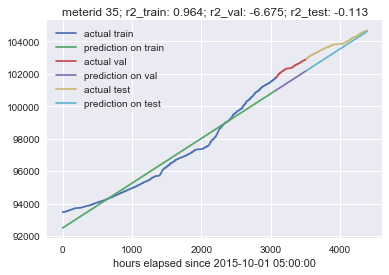

In [19]:
# plot timeseries of predicted and actual values.

plt.title(f'meterid {meterid}; r2_train: {r2_train:.3f}; r2_val: {r2_valid:.3f}; r2_test: {r2_test:.3f}')
plt.xlabel(f'hours elapsed since {df_i.index[0]}') 
plt.plot(x_train, y_train, label='actual train')
plt.plot(x_train, y_train_pred, label='prediction on train')

plt.plot(x_valid, y_valid, label='actual val')
plt.plot(x_valid, y_valid_pred, label='prediction on val')

plt.plot(x_test, y_test, label='actual test')
plt.plot(x_test, y_test_pred, label='prediction on test')

plt.legend()

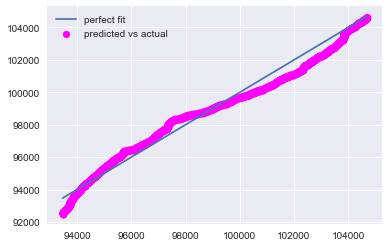

In [20]:
# plot actual vs predicted value
actual = []
actual.extend(y_train)
actual.extend(y_valid)
actual.extend(y_test)
len(actual)

predicted = []
predicted.extend(y_train_pred)
predicted.extend(y_valid_pred)
predicted.extend(y_test_pred)
len(predicted)

plt.scatter(actual, predicted, color='magenta', label='predicted vs actual')
plt.plot(actual, actual, label='perfect fit')
plt.legend()

### Using the above code, write the script for generating results on all relevant meterids
#### Must specify timeperiod of interest.
#### This cell generates individual linear regression models for each relevant meterid, saves the model to harddrive, records scores and regression coefficients.
#### set show_plot to True to print residual plots and prediction error plots.

localminute  marginal_change  meterid  norm_cumul_value
0 2015-12-01 00:00:00              0.0       35               0.0
1 2015-12-01 01:00:00              6.0       35               6.0
2 2015-12-01 02:00:00             32.0       35              38.0
3 2015-12-01 03:00:00              0.0       35              38.0
4 2015-12-01 04:00:00              0.0       35              38.0

localminute  marginal_change  meterid  norm_cumul_value
392956 2016-03-31 12:00:00              0.0     9982           10730.0
392957 2016-03-31 13:00:00              0.0     9982           10730.0
392958 2016-03-31 14:00:00              0.0     9982           10730.0
392959 2016-03-31 15:00:00              0.0     9982           10730.0
392960 2016-03-31 16:00:00             72.0     9982           10802.0

marginal_change        meterid  norm_cumul_value
count    392961.000000  392961.000000     392961.000000
mean          5.536478    4634.156242       9144.448431
std          18.731702    2921.372500       7352.521423
min           0.000000      35.000000          0.000000
25%           0.000000    2034.000000       2914.000000
50%           0.000000    4352.000000       8042.000000
75%           4.000000    7117.000000      13588.000000
max        1596.000000    9982.000000      45670.000000

localminute  marginal_change  meterid  norm_cumul_value  label
0 2015-12-01 00:00:00              0.0       35               0.0      0
1 2015-12-01 01:00:00              6.0       35               6.0      0
2 2015-12-01 02:00:00             32.0       35              38.0      0
3 2015-12-01 03:00:00              0.0       35              38.0      0
4 2015-12-01 04:00:00              0.0       35              38.0      0

139

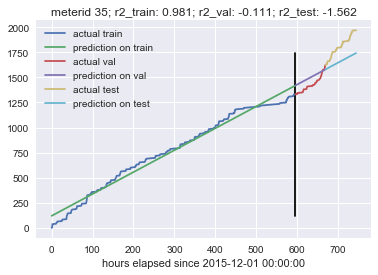

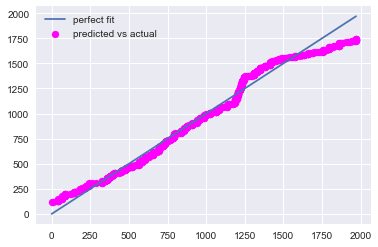

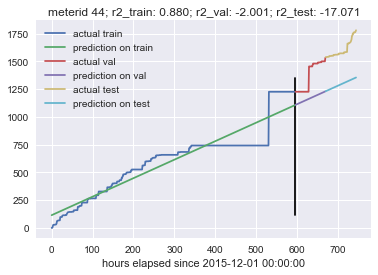

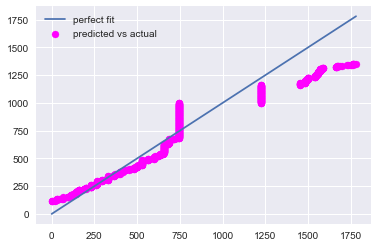

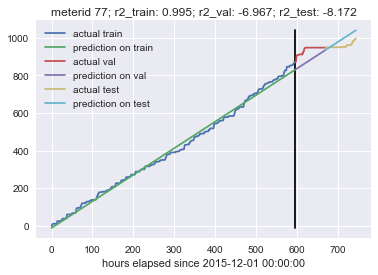

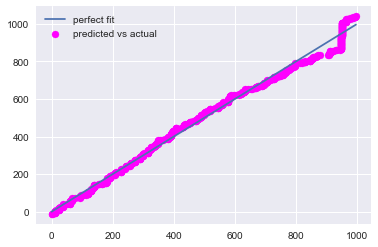

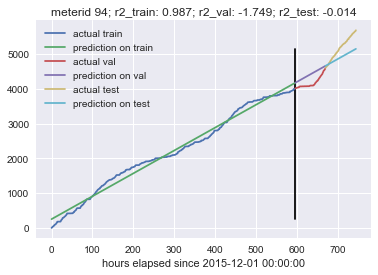

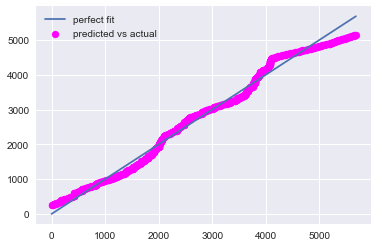

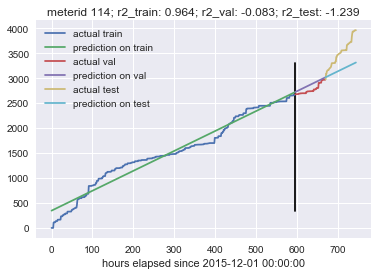

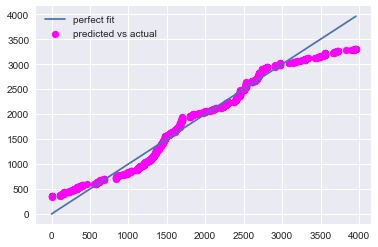

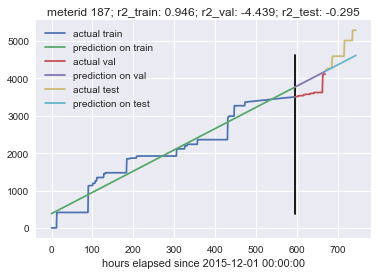

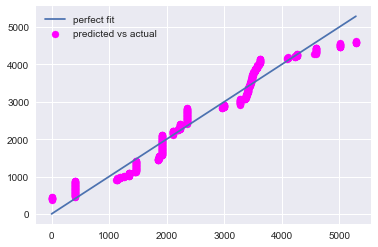

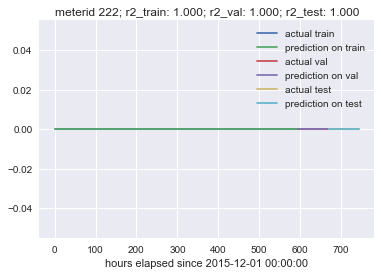

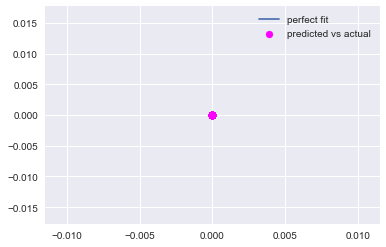

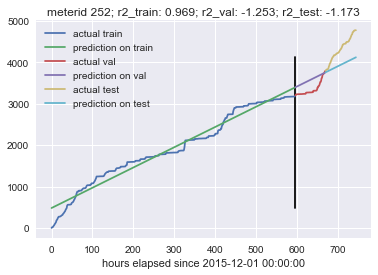

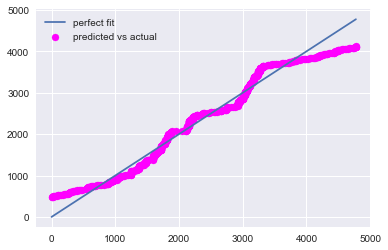

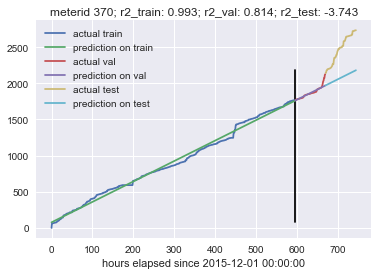

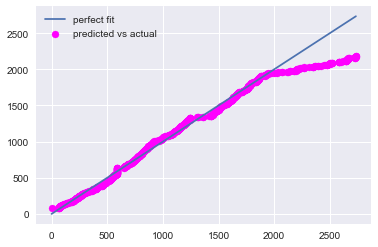

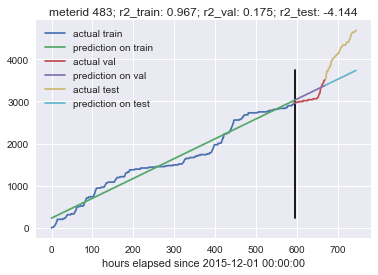

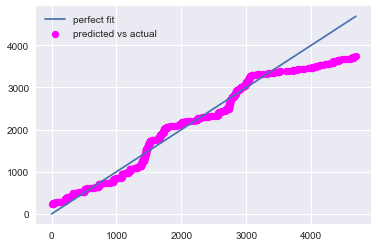

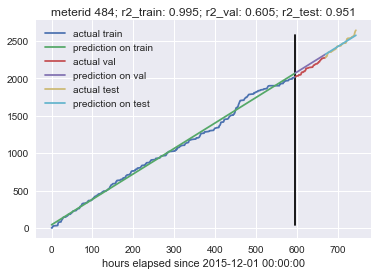

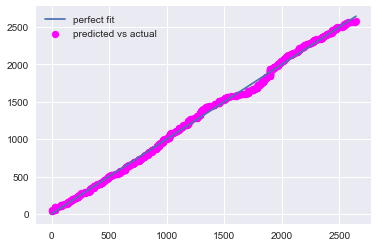

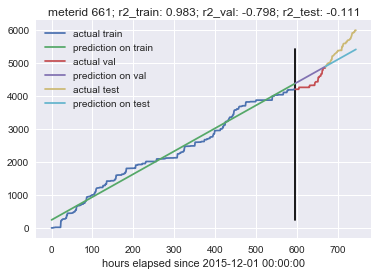

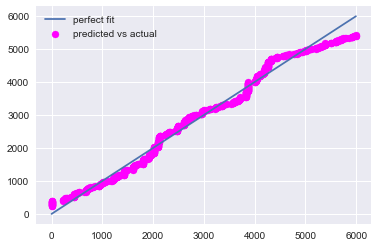

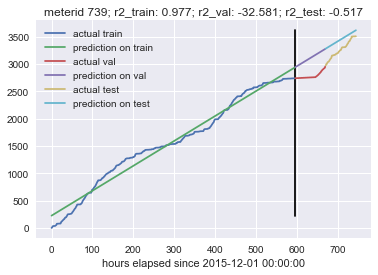

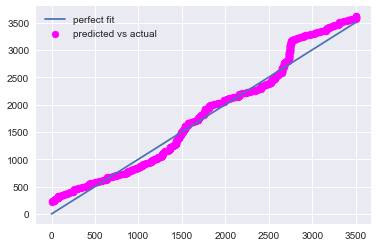

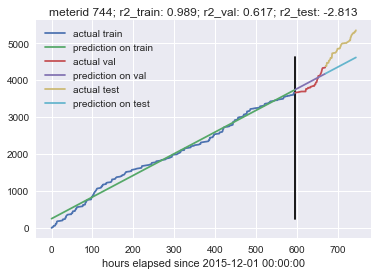

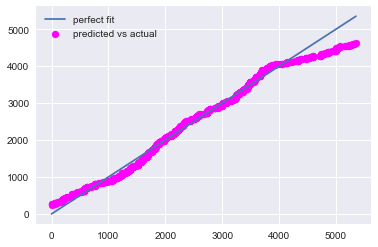

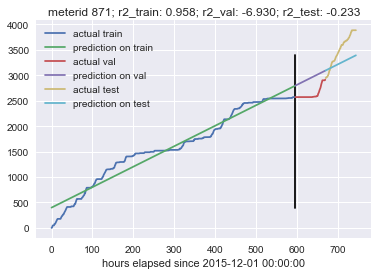

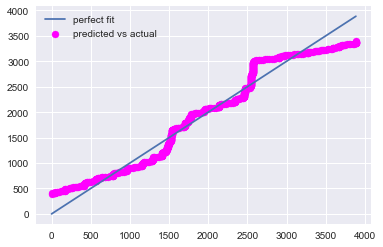

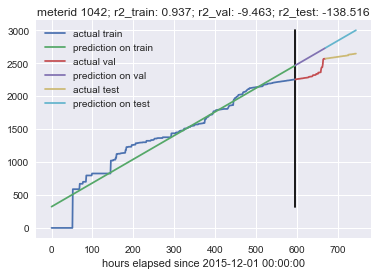

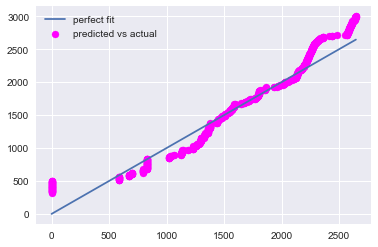

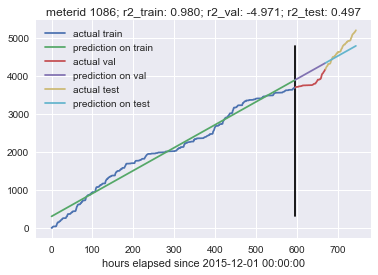

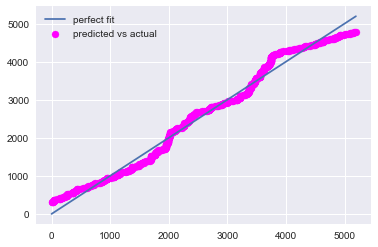

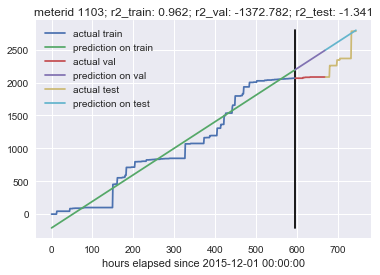

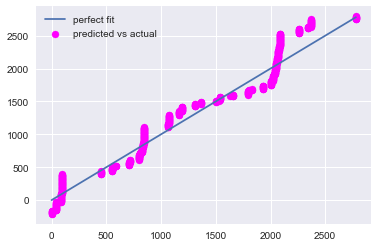

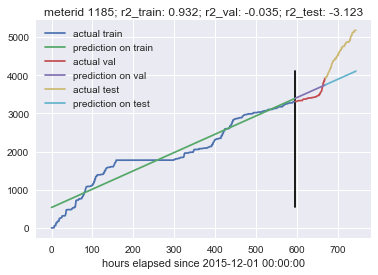

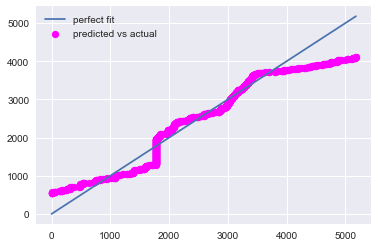

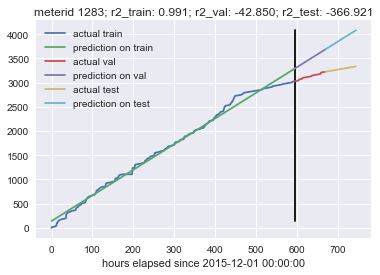

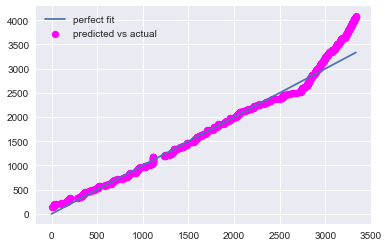

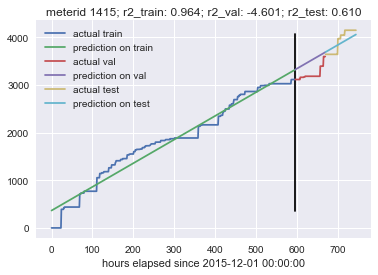

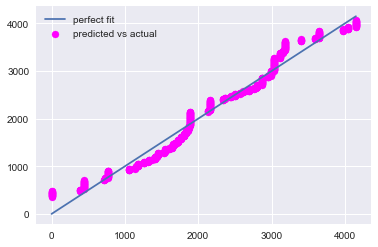

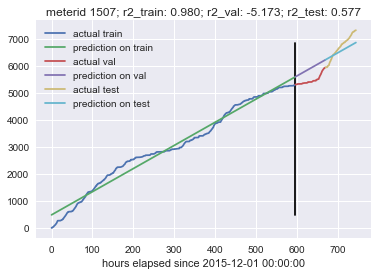

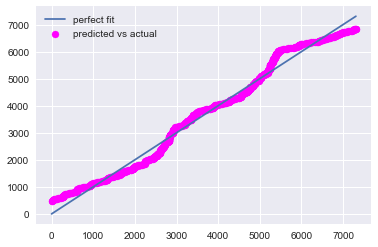

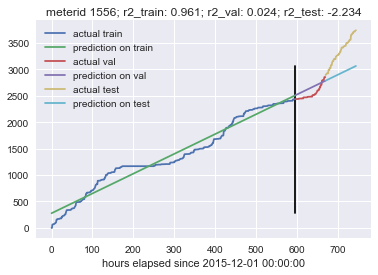

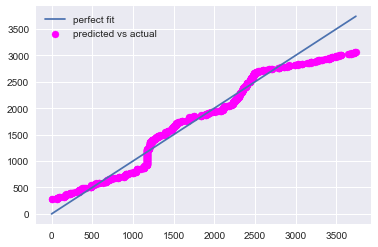

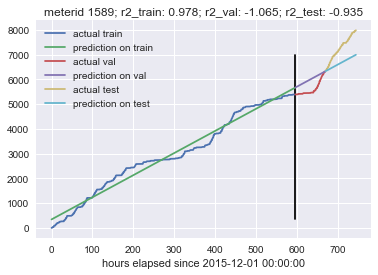

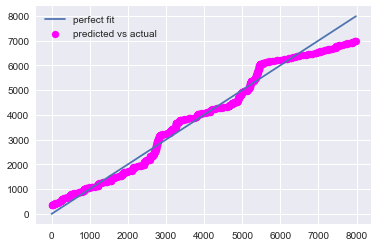

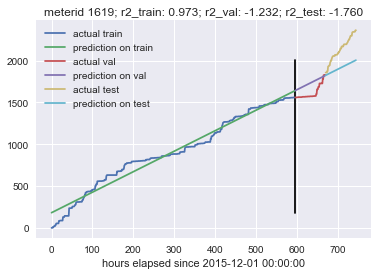

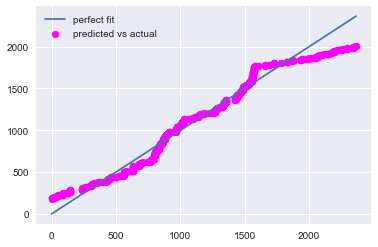

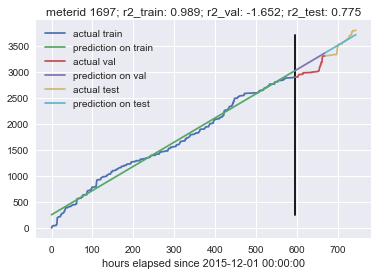

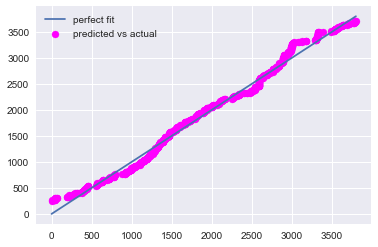

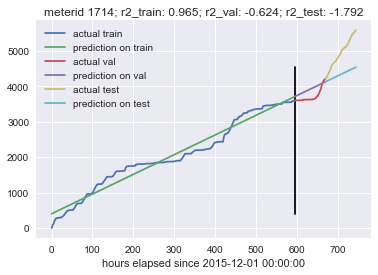

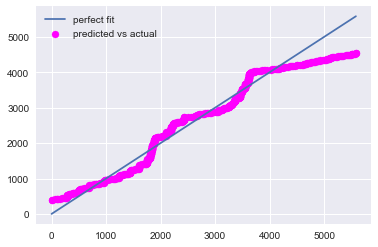

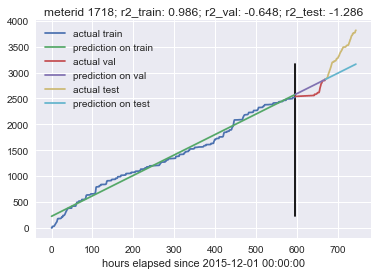

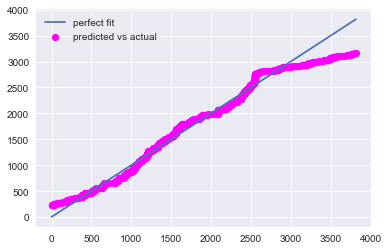

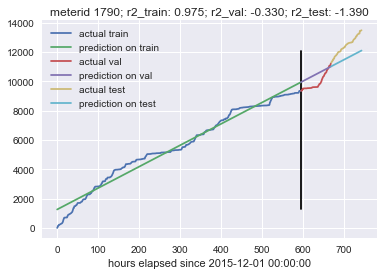

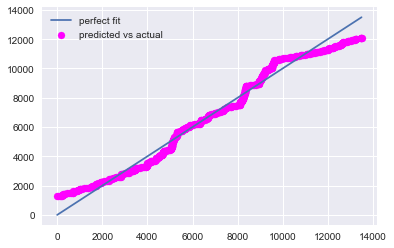

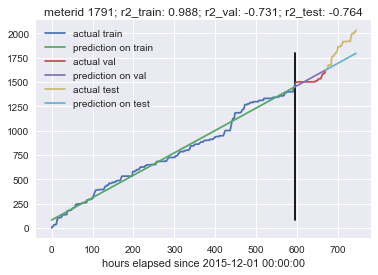

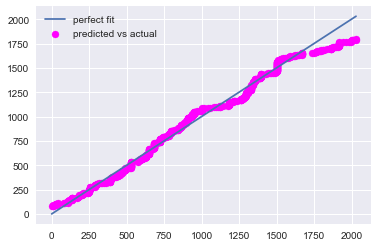

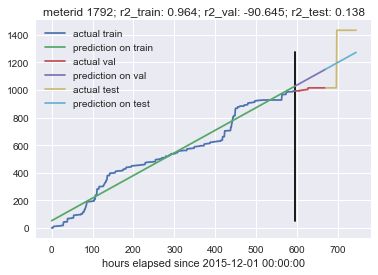

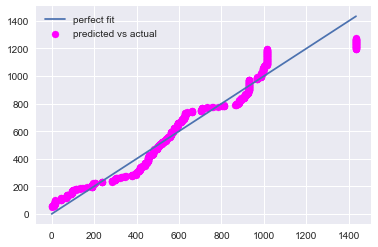

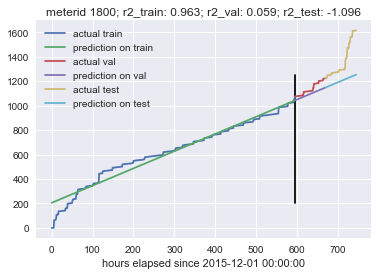

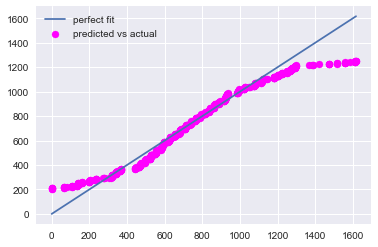

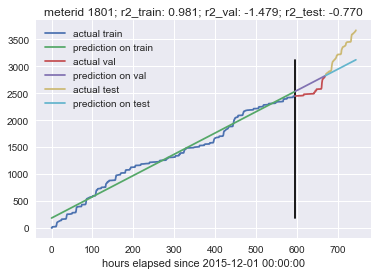

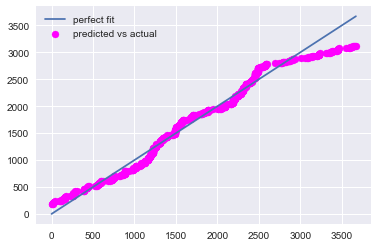

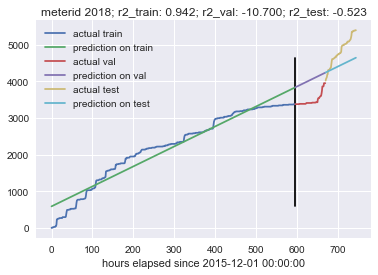

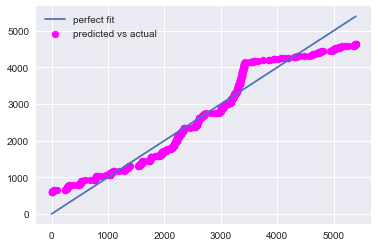

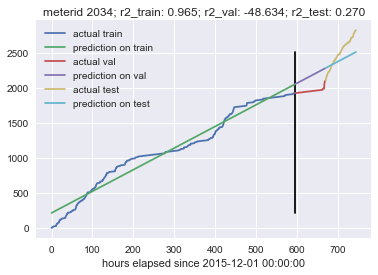

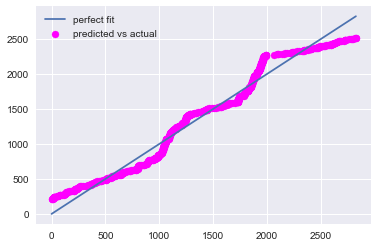

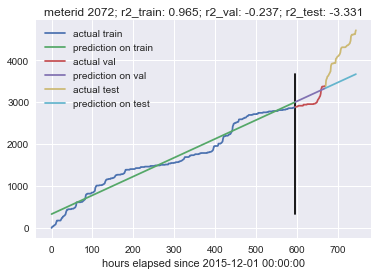

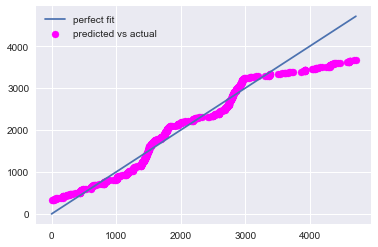

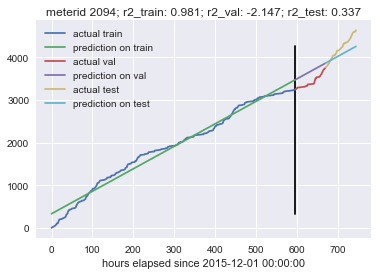

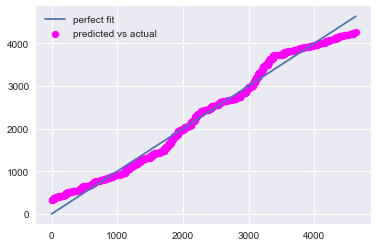

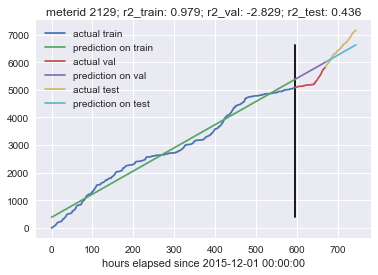

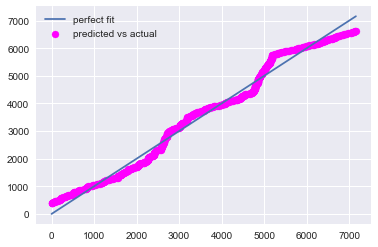

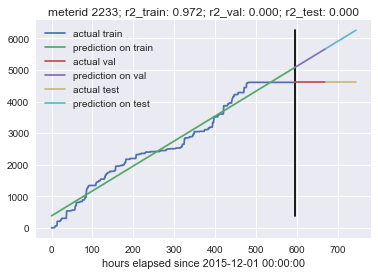

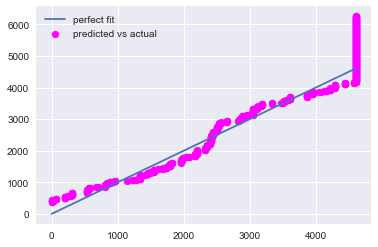

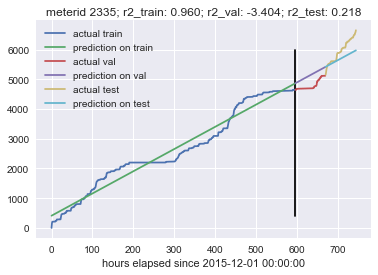

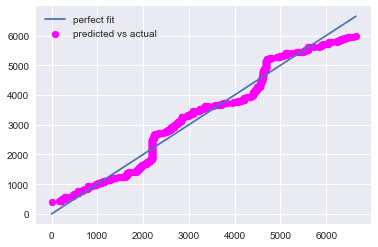

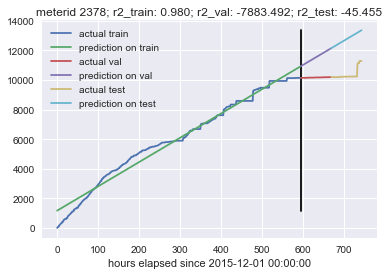

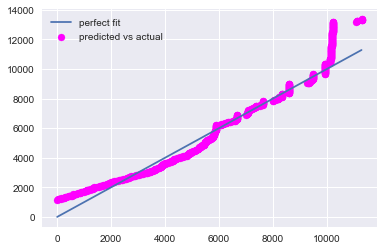

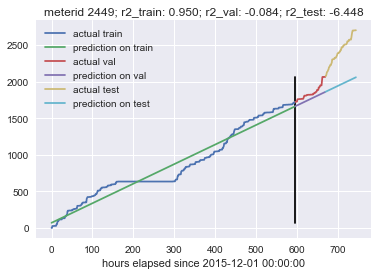

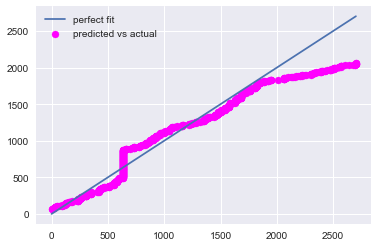

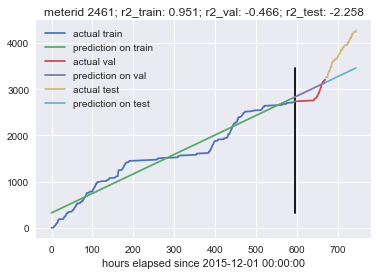

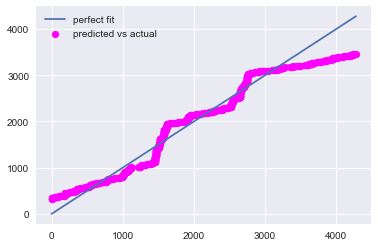

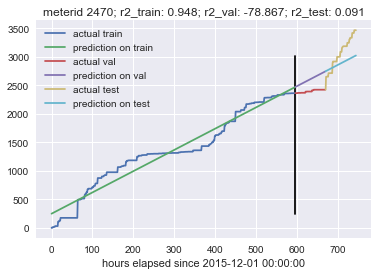

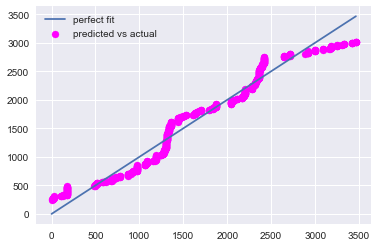

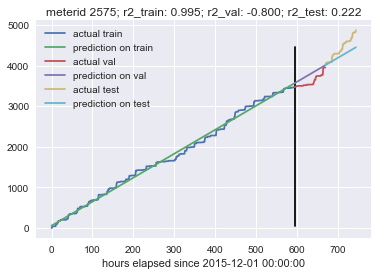

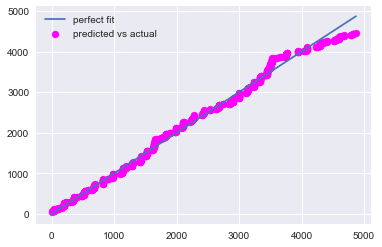

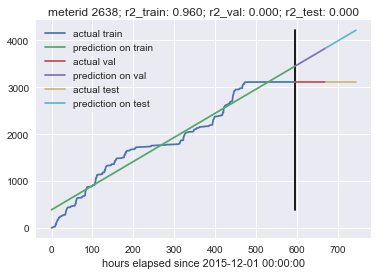

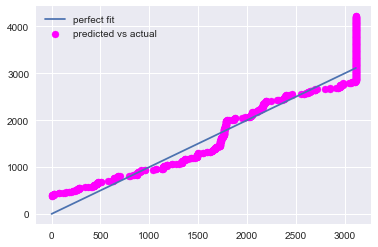

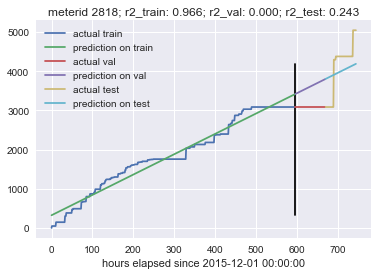

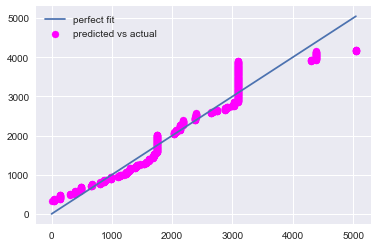

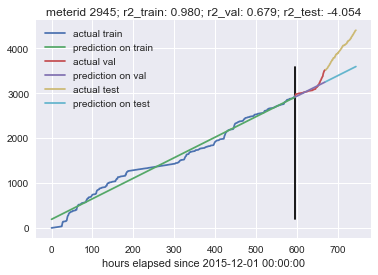

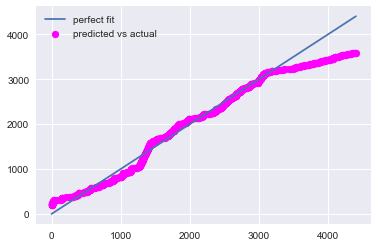

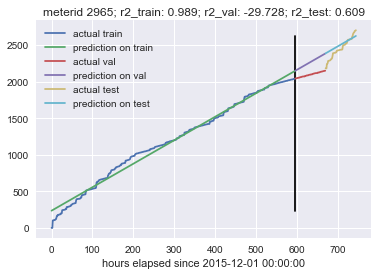

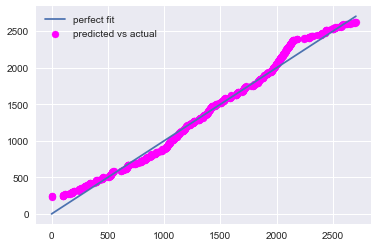

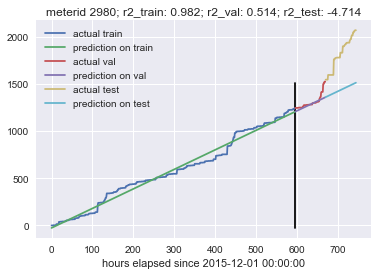

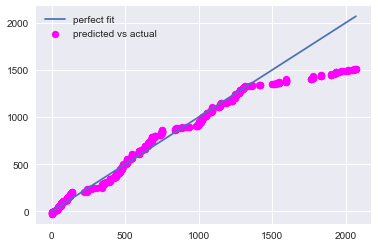

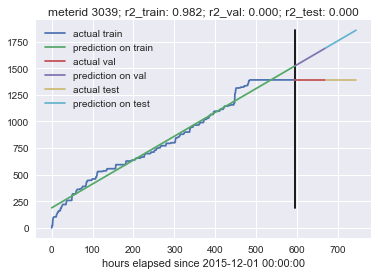

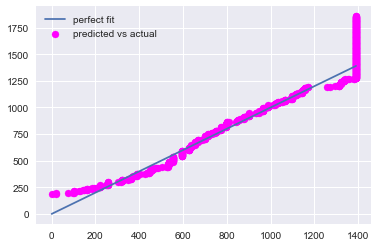

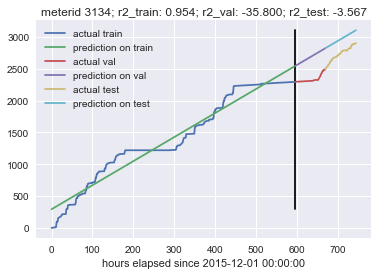

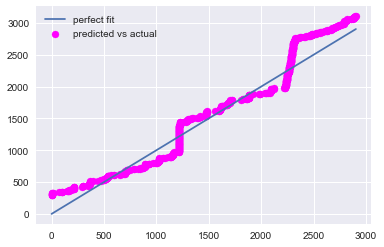

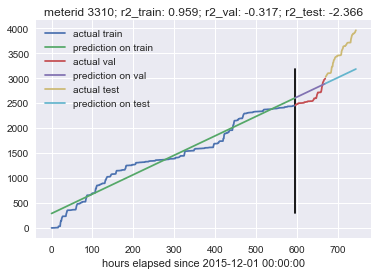

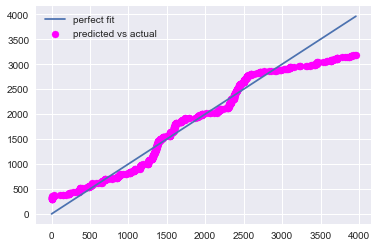

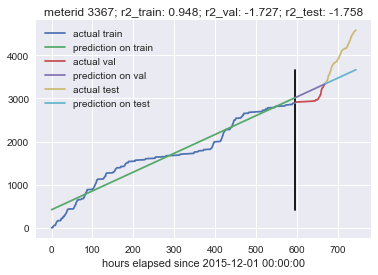

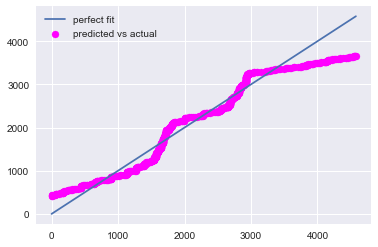

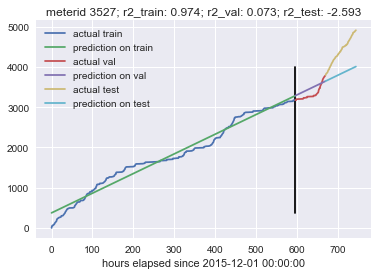

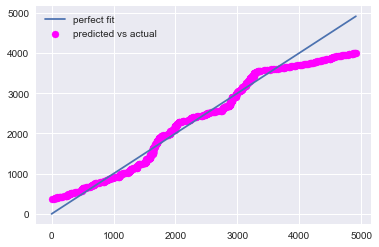

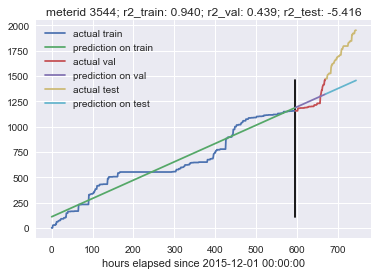

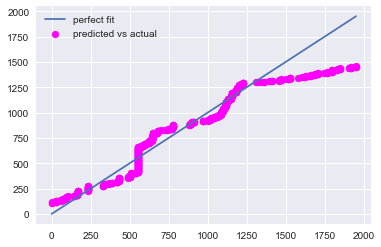

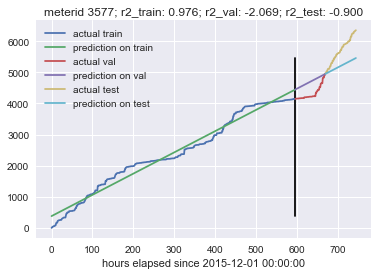

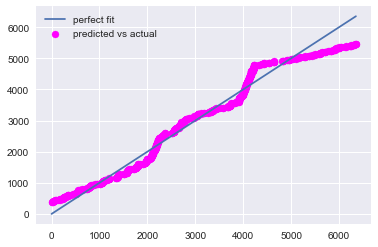

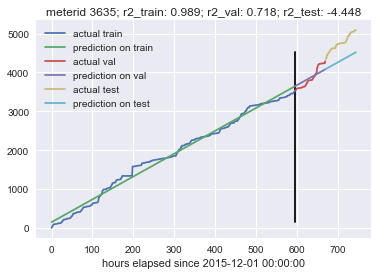

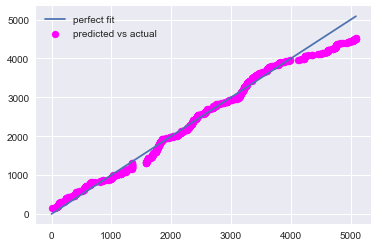

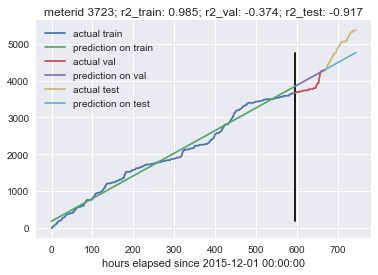

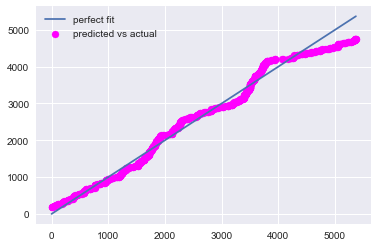

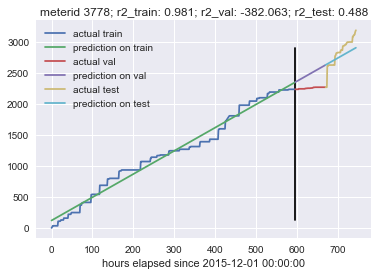

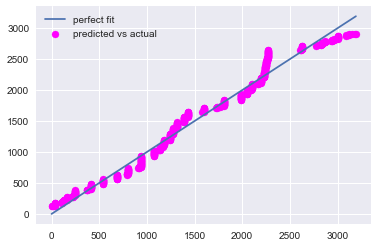

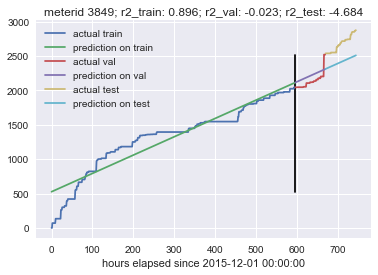

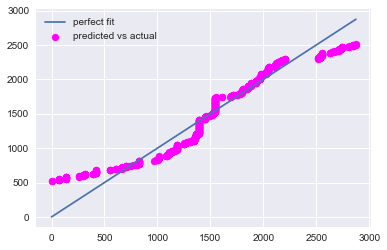

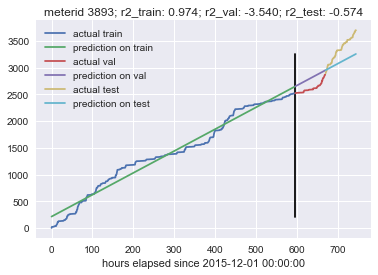

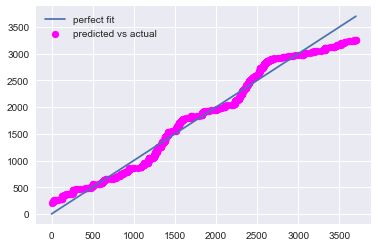

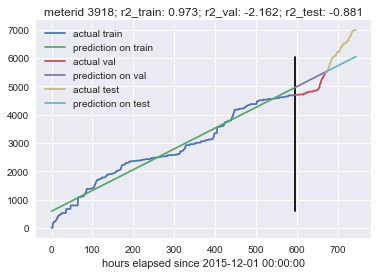

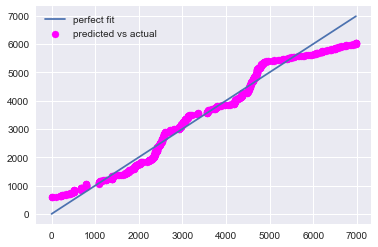

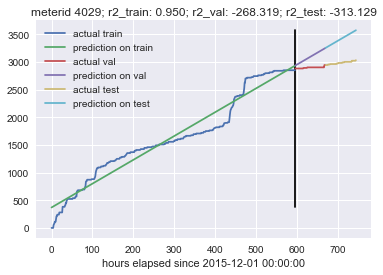

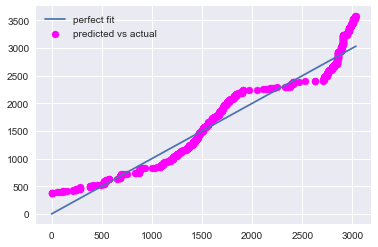

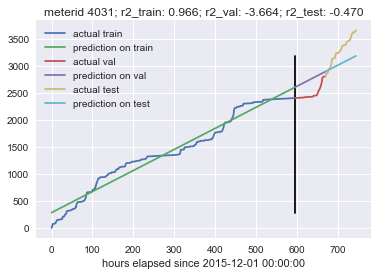

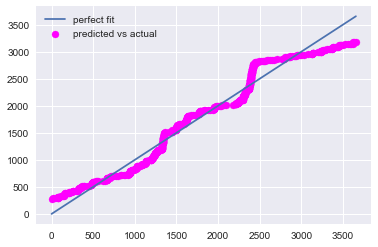

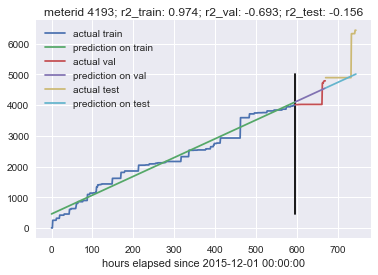

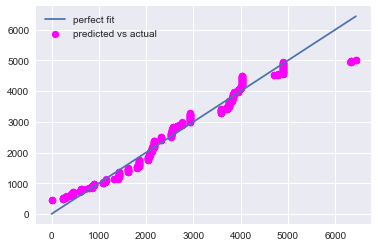

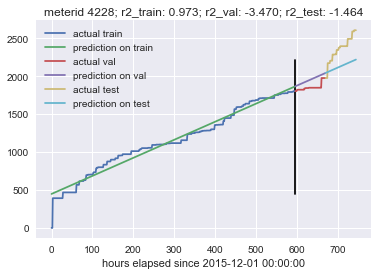

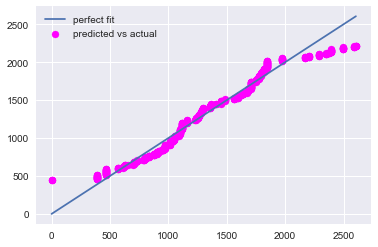

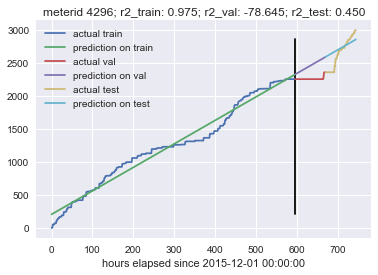

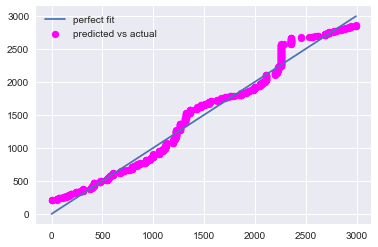

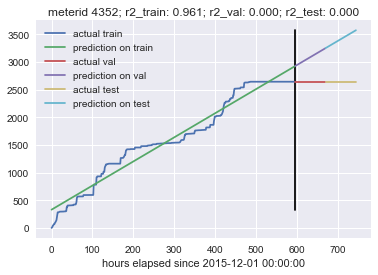

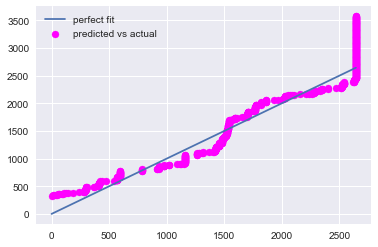

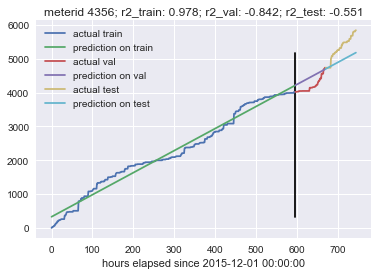

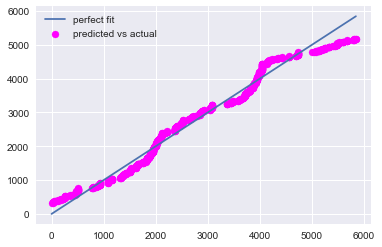

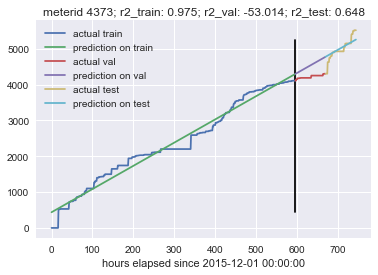

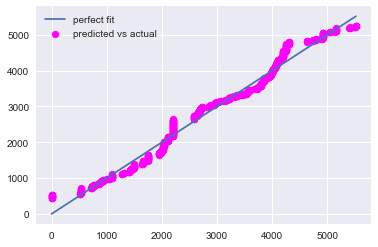

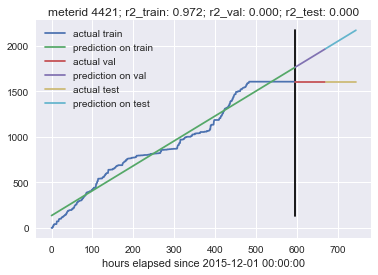

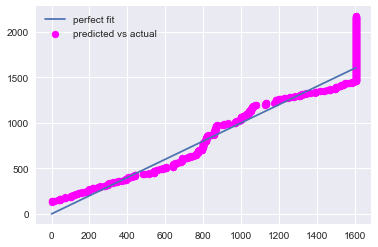

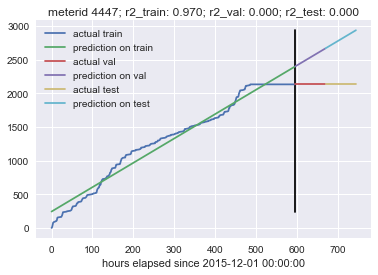

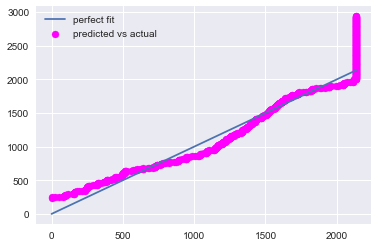

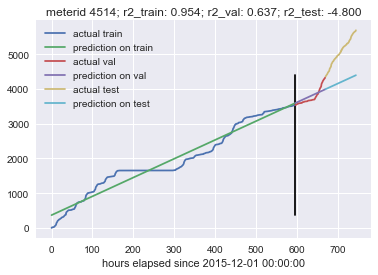

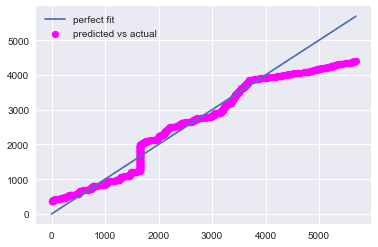

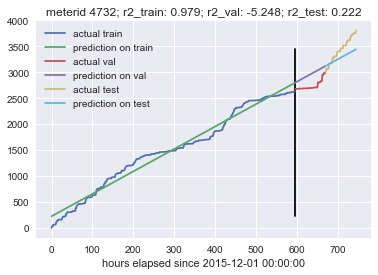

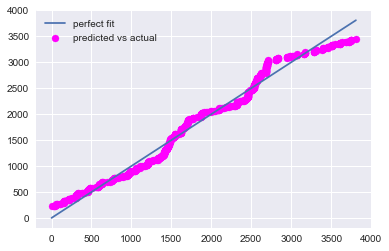

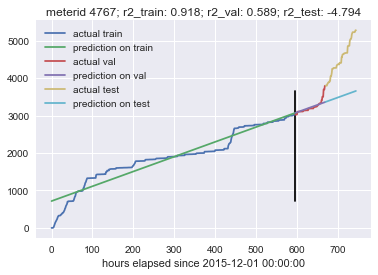

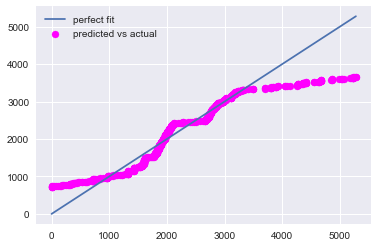

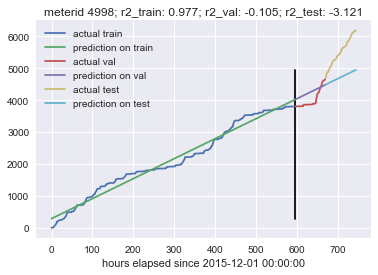

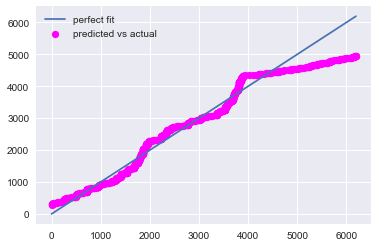

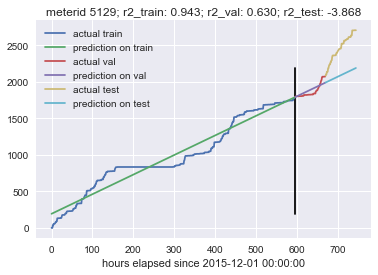

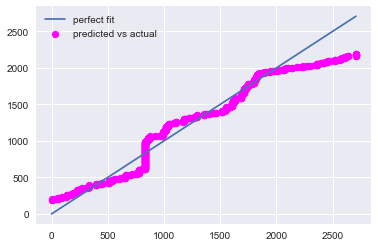

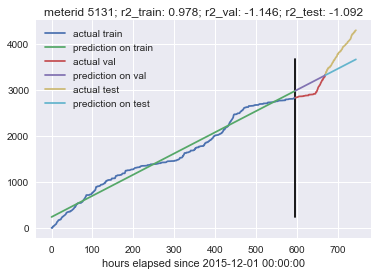

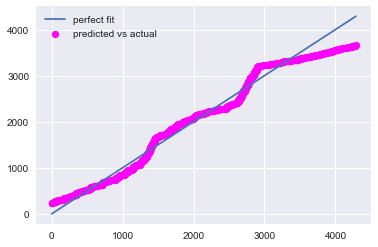

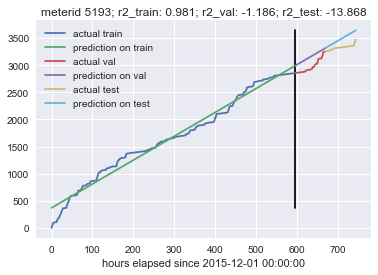

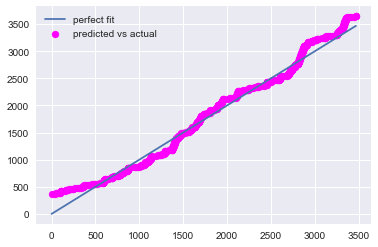

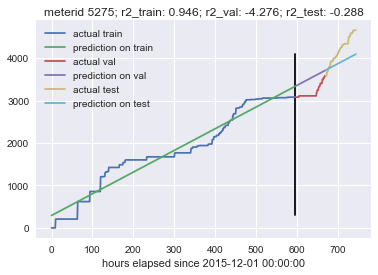

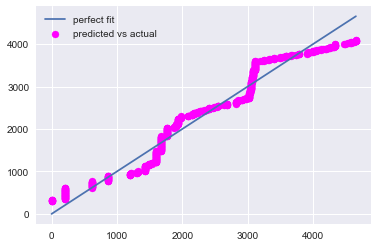

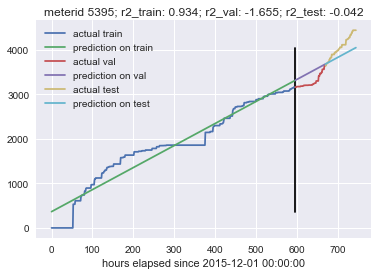

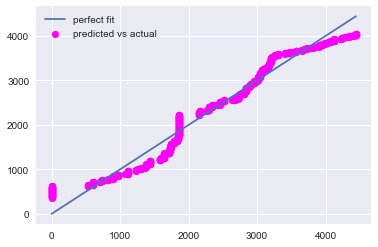

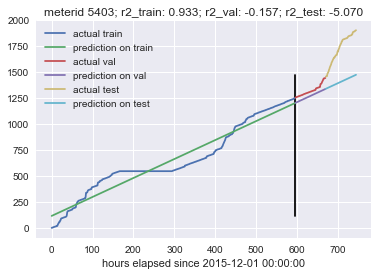

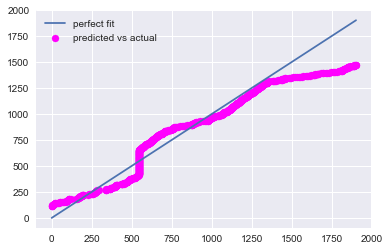

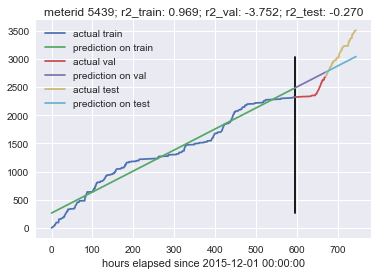

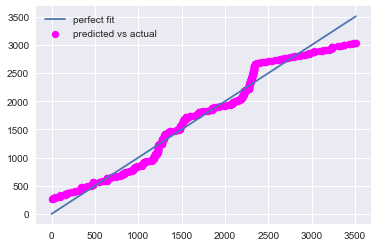

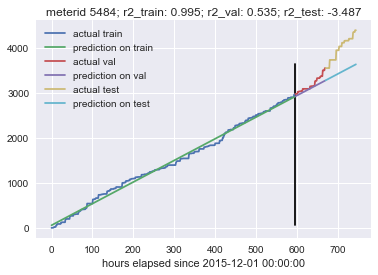

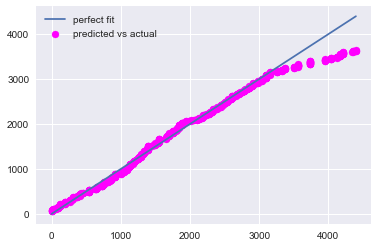

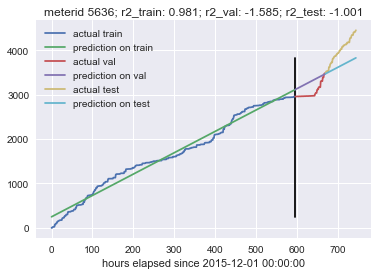

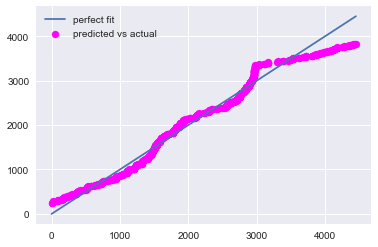

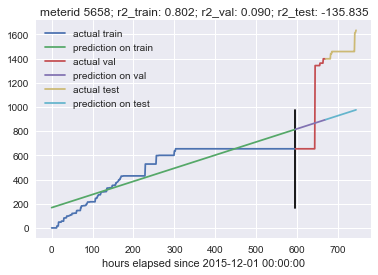

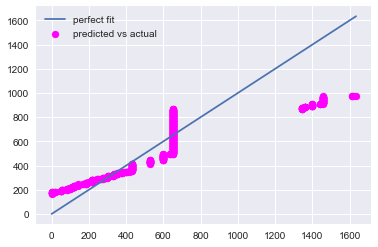

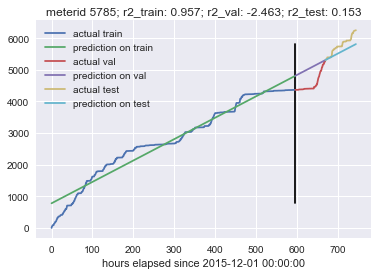

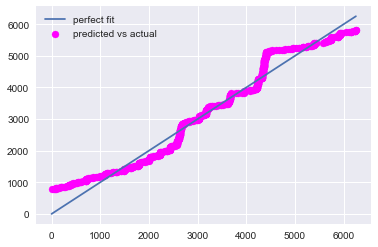

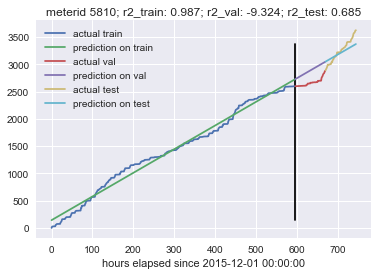

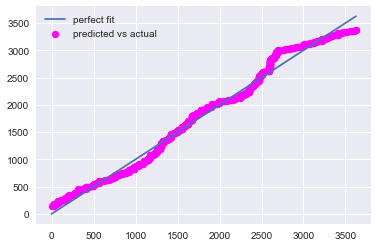

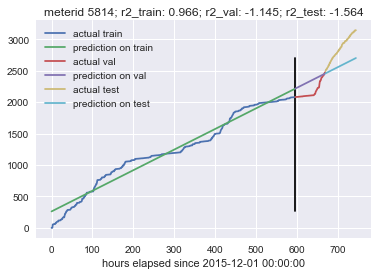

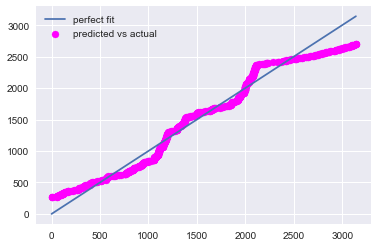

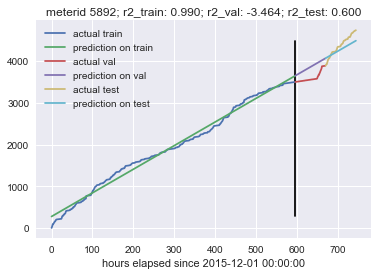

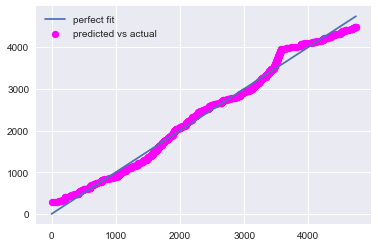

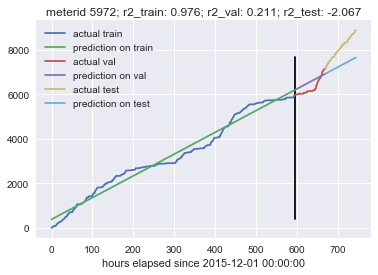

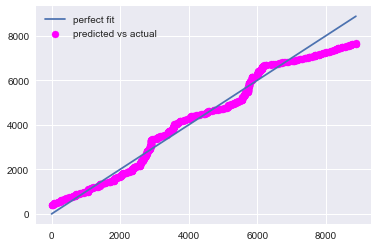

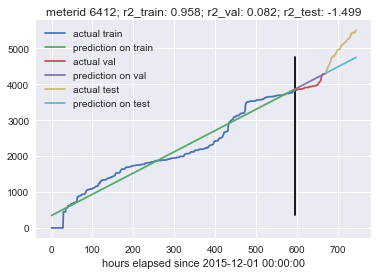

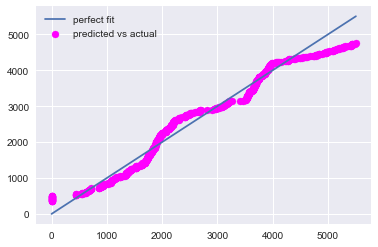

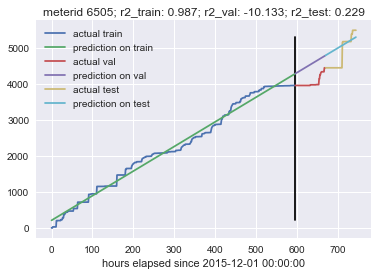

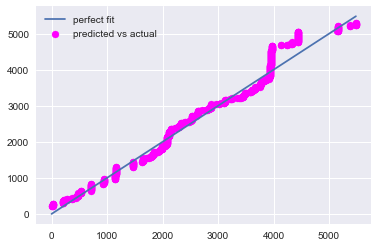

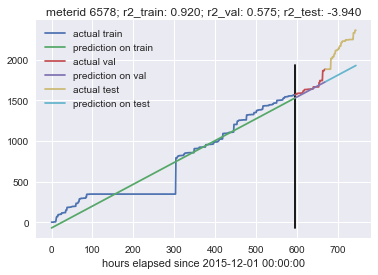

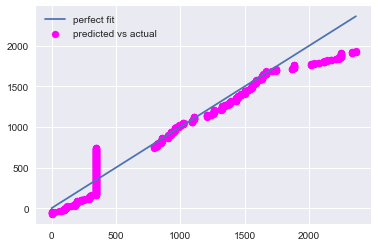

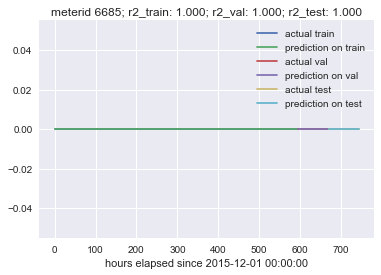

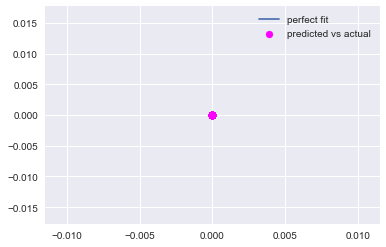

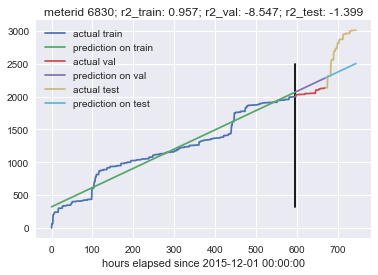

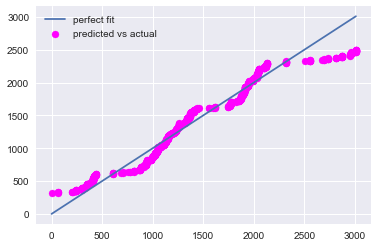

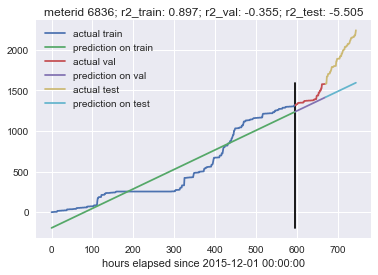

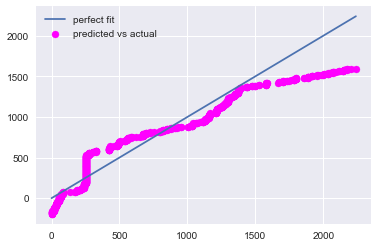

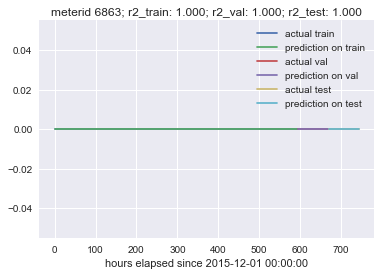

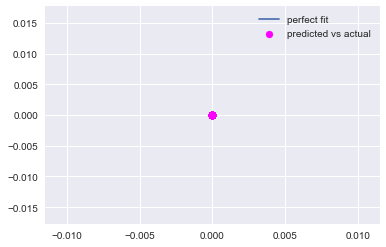

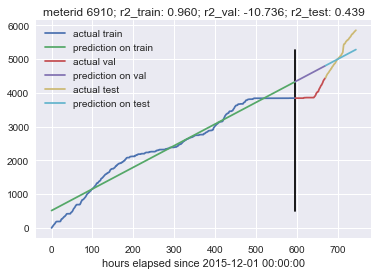

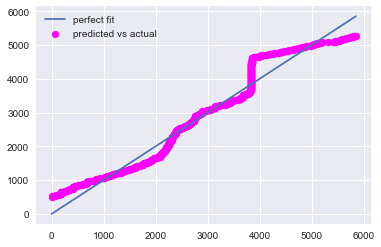

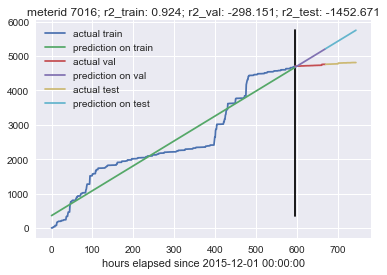

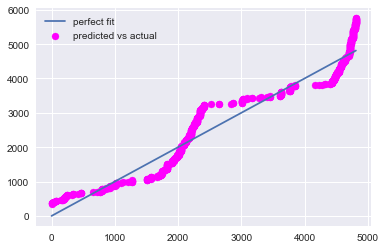

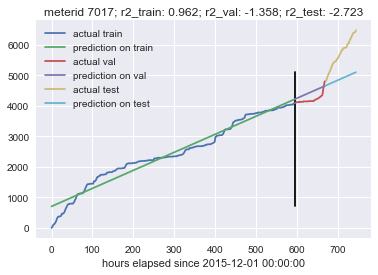

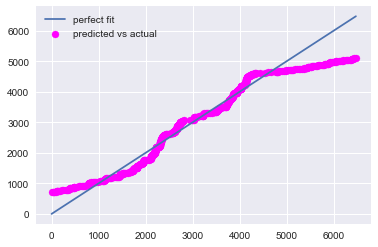

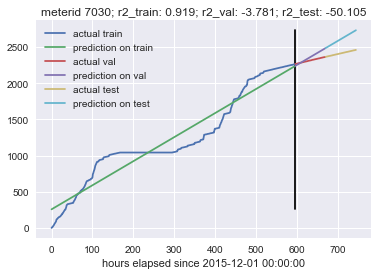

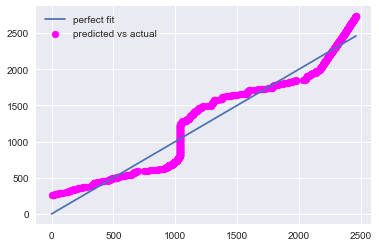

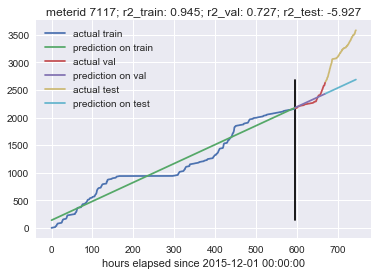

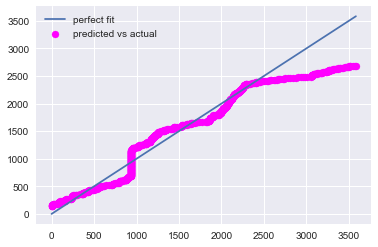

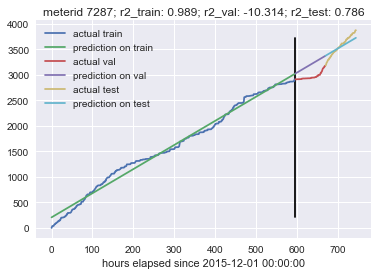

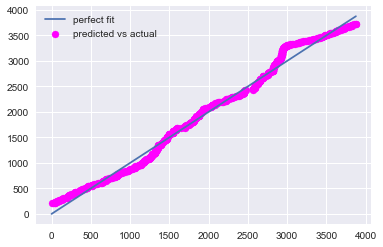

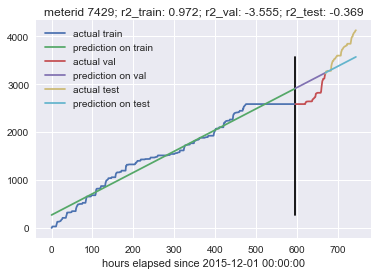

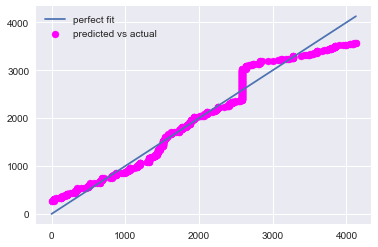

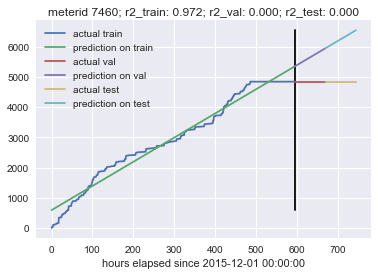

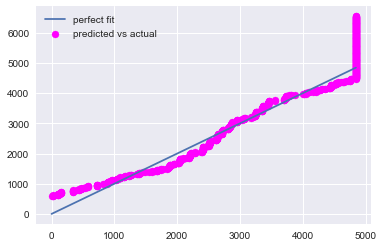

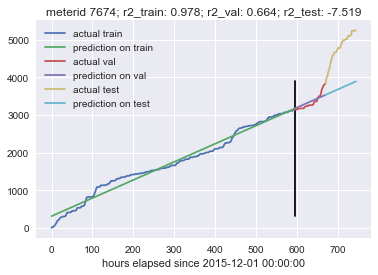

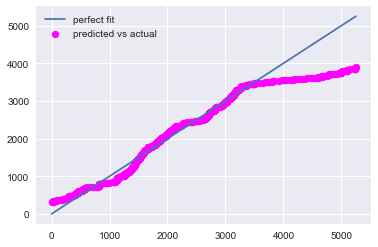

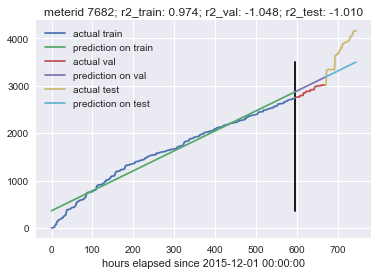

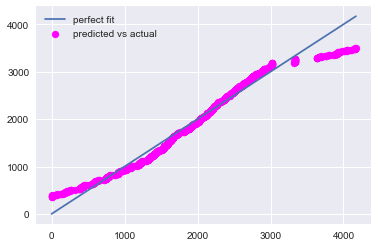

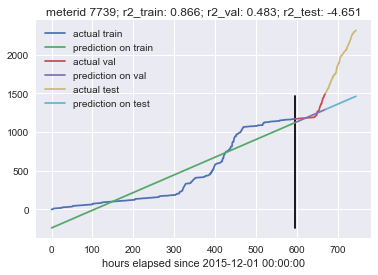

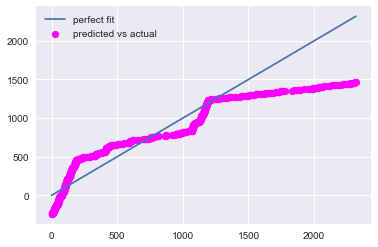

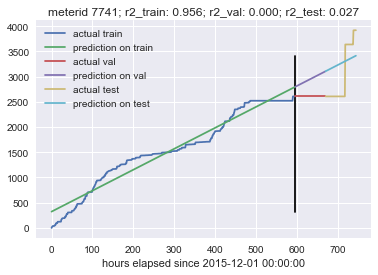

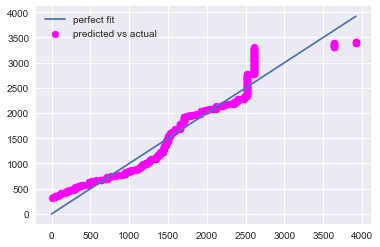

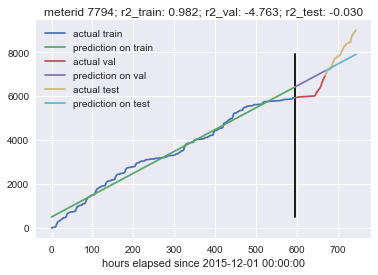

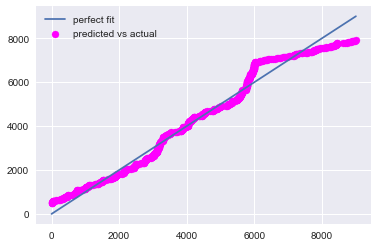

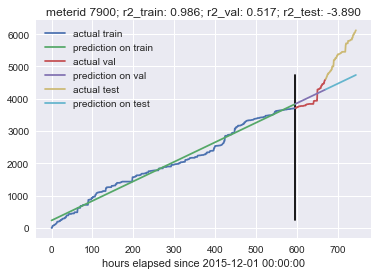

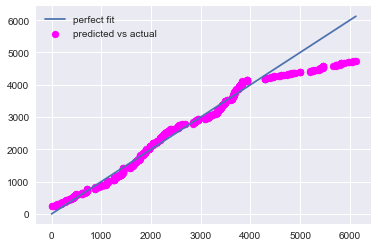

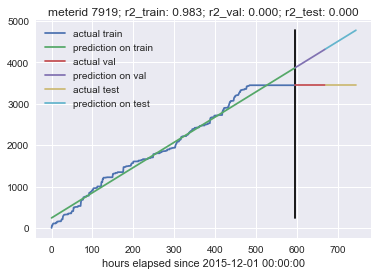

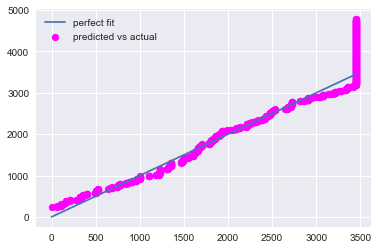

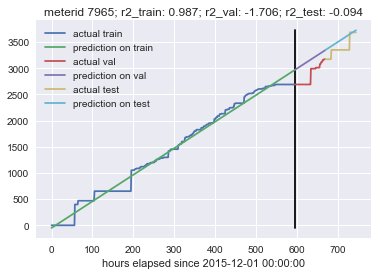

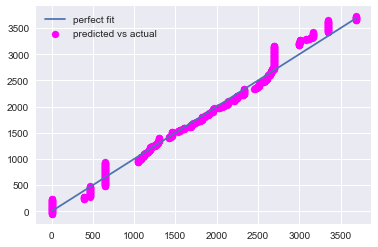

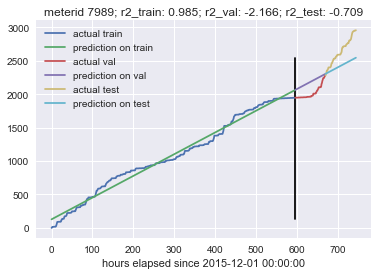

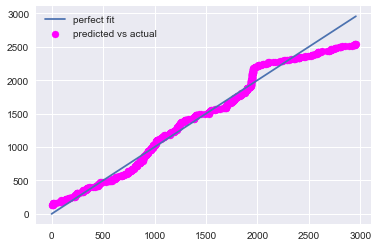

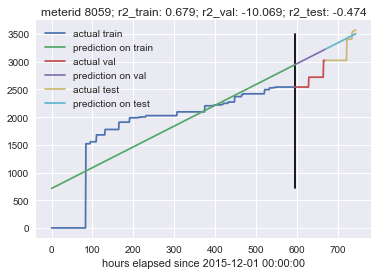

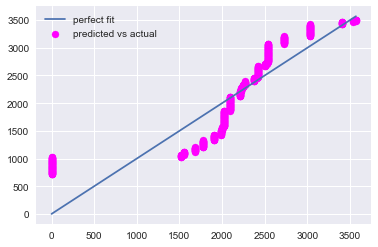

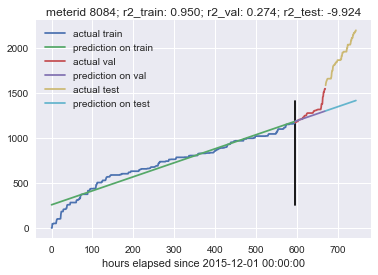

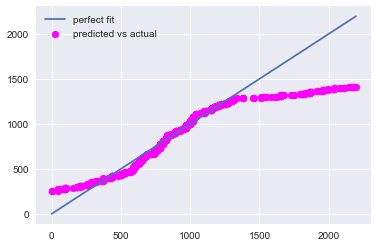

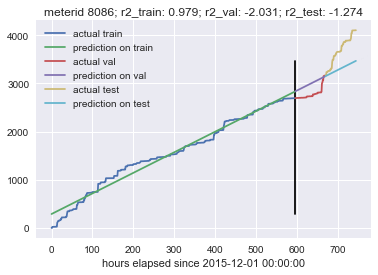

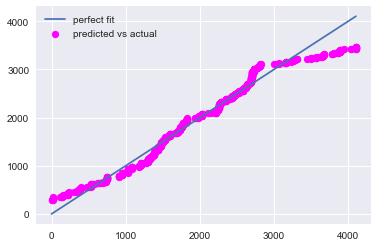

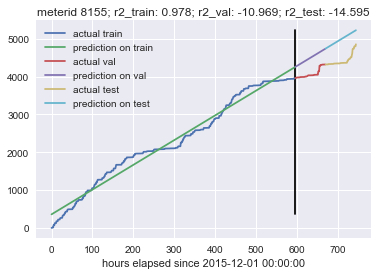

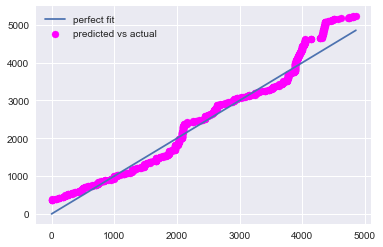

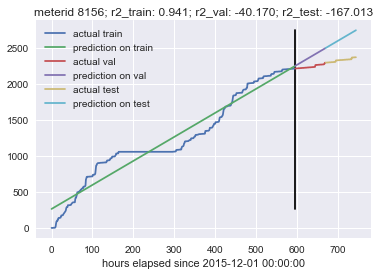

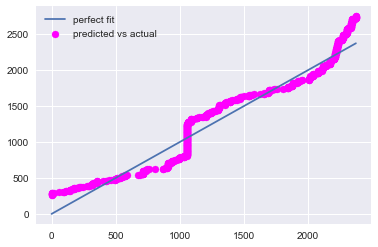

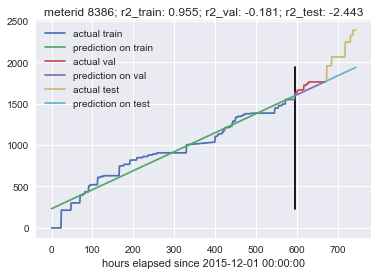

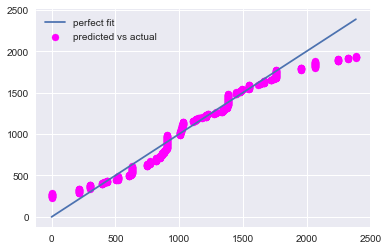

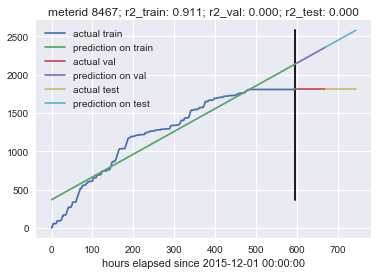

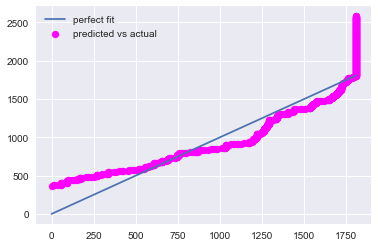

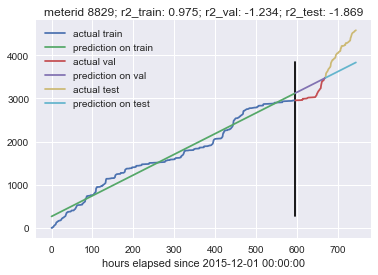

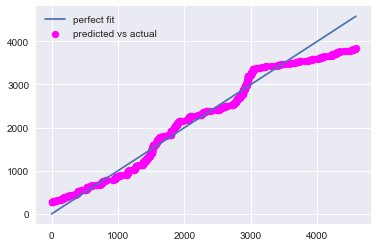

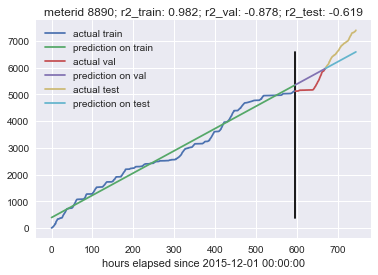

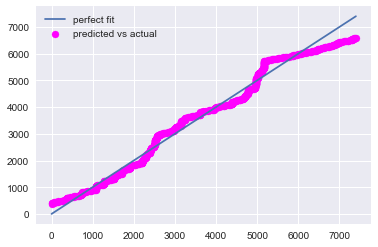

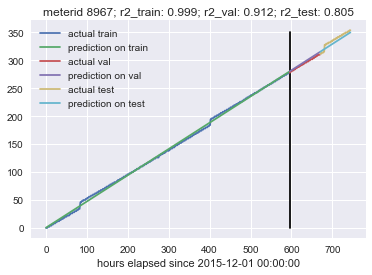

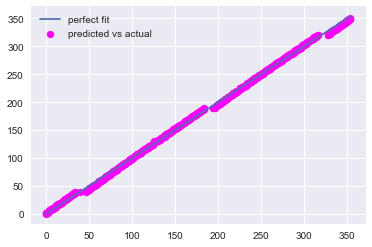

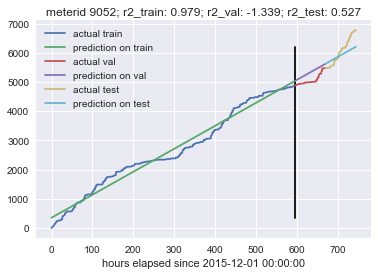

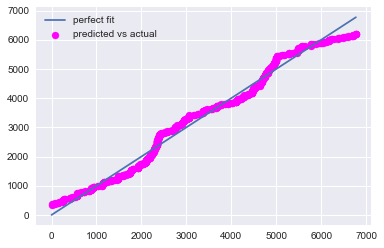

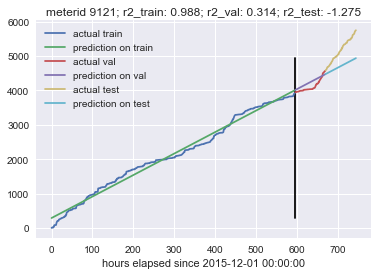

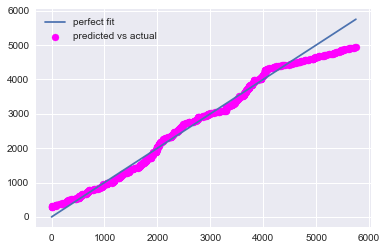

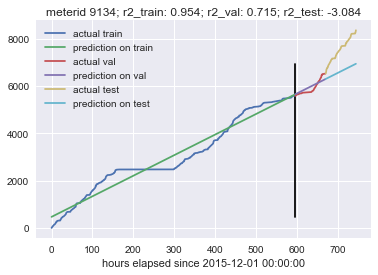

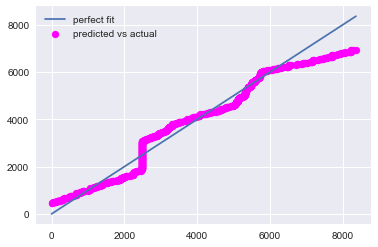

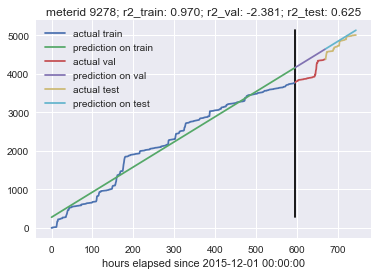

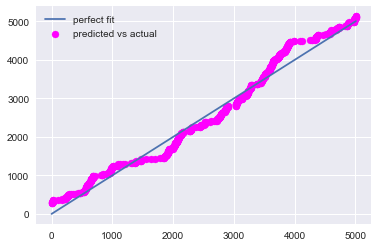

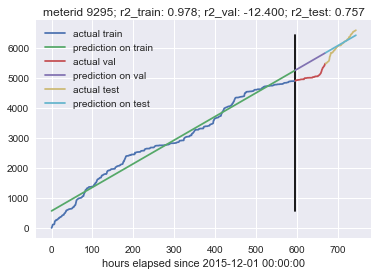

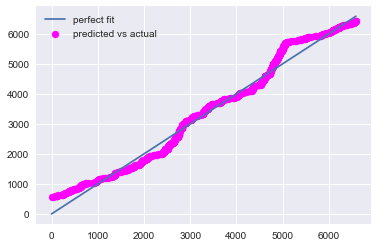

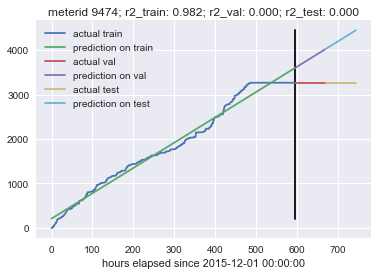

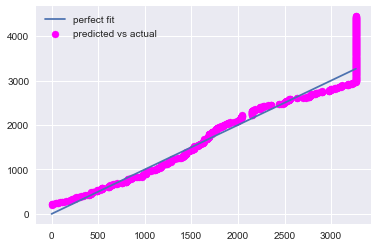

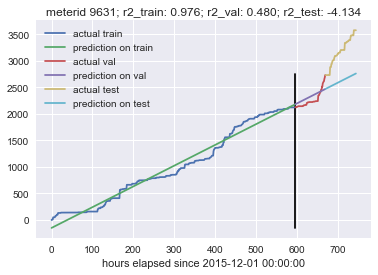

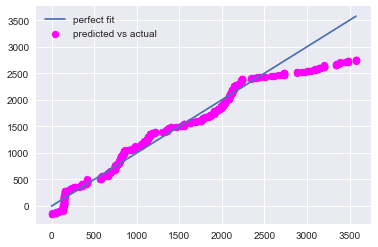

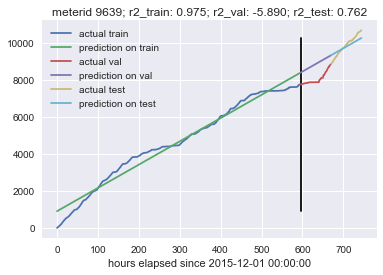

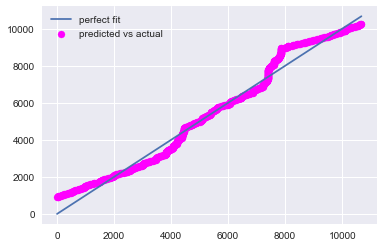

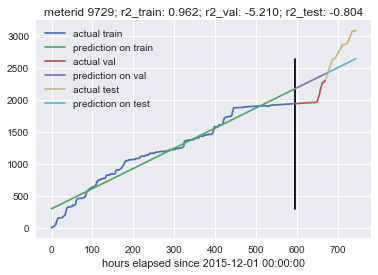

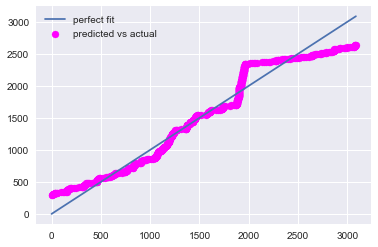

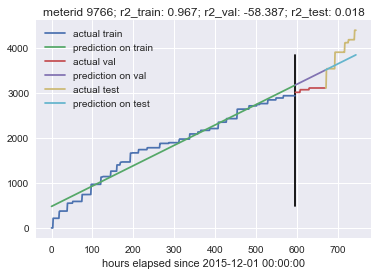

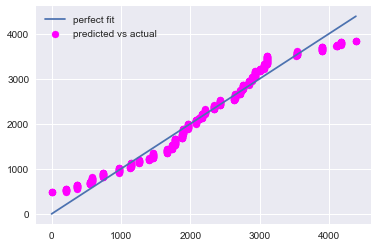

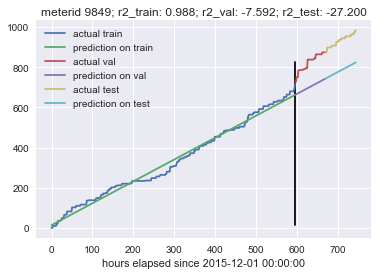

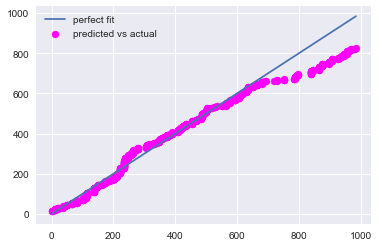

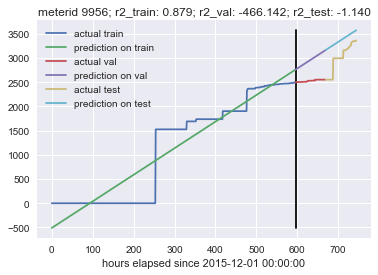

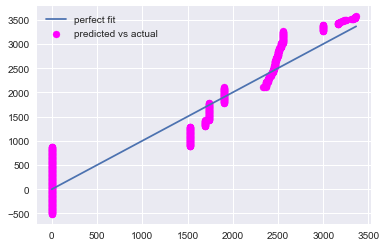

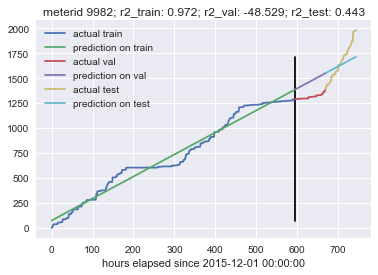

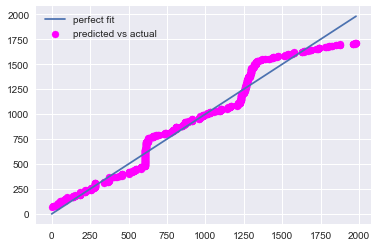

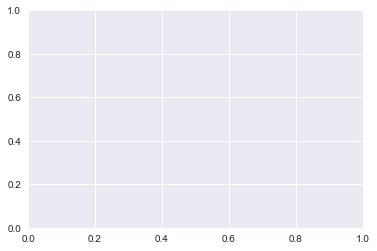

In [22]:
from joblib import dump, load

# Normalize values and obtain new df with relevant meterids.

origin_date = '2015-12-01' # starting date to normalize x axis (time in hours) to.
end_date = '2016-01-01' # the df must have data until a datetime >= end_date.

df_normalized = normalize_and_combine(origin_date, end_date)
display(df_normalized.head(), df_normalized.tail(), df_normalized.describe())

le = LabelEncoder()
labels = le.fit_transform(df_normalized['meterid'])
df_normalized = df_normalized.assign(label=labels)
display(df_normalized.head())

new_groups = df_normalized.groupby('meterid')
new_keys = new_groups.groups.keys()  # keys: an iterable of dataids or meter ids

new_id_list = list(new_keys)
display(len(new_id_list))

coeffs = []
scores = []
show_plot = True

for meterid in new_id_list:
    df_i = new_groups.get_group(meterid)
    
    # zoom in on specified time period.
    df_i = zoom(df_i, origin_date, end_date)

    # convert DateTimeIndex to numerical values (ints) for regression.
    X = np.arange(start=0, stop=len(df_i.index), step=1).reshape(-1, 1)
    y = df_i['norm_cumul_value']
    
    # split dataset
    valid_start, test_start = int(len(df_i)*0.8), int(len(df_i)*0.9)
    x_train, x_valid, x_test = X[:valid_start,:], X[valid_start:test_start,:], X[test_start:,:]
    y_train, y_valid, y_test = y[:valid_start], y[valid_start:test_start], y[test_start:]
    
    # TODO: make below code generalized for reuse with other models.
    
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    dump(lr_model, f'models/lr_{meterid}.joblib') # save model to hard disk.
    
    # record coefficients
    coeffs.append((lr_model.intercept_, lr_model.coef_))
    
    #run predictions and get scores
    y_train_pred = lr_model.predict(x_train)
    r2_train = lr_model.score(x_train, y_train)

    y_valid_pred = lr_model.predict(x_valid)
    r2_valid = lr_model.score(x_valid, y_valid)

    y_test_pred = lr_model.predict(x_test)
    r2_test = lr_model.score(x_test, y_test)
    
    # record scores
    scores.append((r2_train, r2_valid, r2_test))
    
    # show residual plots and prediction error plots.
    if show_plot: 
        #TODO: plot both plots side by side.
        
        # plot line demarcating end of training data.
        test_mark = X[valid_start][0]
        plt.plot([test_mark, test_mark], [y_train_pred.min(), y_test_pred.max()], 'k-')

        # plot trendline and actual line.
        plt.title(f'meterid {meterid}; r2_train: {r2_train:.3f}; r2_val: {r2_valid:.3f}; r2_test: {r2_test:.3f}')
        plt.xlabel(f'hours elapsed since {df_i.localminute.iloc[0]}') 
        plt.plot(x_train, y_train, label='actual train')
        plt.plot(x_train, y_train_pred, label='prediction on train')

        plt.plot(x_valid, y_valid, label='actual val')
        plt.plot(x_valid, y_valid_pred, label='prediction on val')

        plt.plot(x_test, y_test, label='actual test')
        plt.plot(x_test, y_test_pred, label='prediction on test')

        plt.legend()
        plt.show()
        plt.cla()

        # plot prediction error plot (actual vs predicted value)
        actual = []
        actual.extend(y_train)
        actual.extend(y_valid)
        actual.extend(y_test)
        len(actual)

        predicted = []
        predicted.extend(y_train_pred)
        predicted.extend(y_valid_pred)
        predicted.extend(y_test_pred)
        len(predicted)

        plt.scatter(actual, predicted, color='magenta', label='predicted vs actual')
        plt.plot(actual, actual, label='perfect fit')
        plt.legend()

        plt.show()
        plt.cla()

In [24]:
# put coefficients and scores of each linear regression into a df.

list1 = [coeffs[i][0] for i in range(len(coeffs))]
list2 = [coeffs[i][1][0] for i in range(len(coeffs))]
list3 = [scores[i][0] for i in range(len(scores))]
list4 = [scores[i][1] for i in range(len(scores))]
list5 = [scores[i][2] for i in range(len(scores))]

df_regresults = pd.DataFrame()
df_regresults = df_regresults.assign(intercept=list1,\
                                     coeff=list2,\
                                     r2_train=list3,\
                                     r2_valid=list4,\
                                     r2_test=list5)

display(df_regresults.head(), df_regresults.describe())

intercept     coeff  r2_train  r2_valid    r2_test
0  120.340360  2.180459  0.981107 -0.110926  -1.561804
1  114.837172  1.666105  0.880162 -2.001399 -17.071187
2  -11.890122  1.414678  0.994812 -6.967014  -8.172406
3  252.291558  6.579021  0.986536 -1.749135  -0.013842
4  345.870325  3.989055  0.964241 -0.083106  -1.238599

intercept       coeff    r2_train     r2_valid      r2_test
count   139.000000  139.000000  139.000000   139.000000   139.000000
mean    279.692029    4.735004    0.963255   -83.040789   -20.971870
std     227.349562    2.488599    0.037029   679.084484   130.610131
min    -509.552595    0.000000    0.678922 -7883.492040 -1452.670895
25%     182.705120    3.262643    0.957323    -5.071646    -3.408876
50%     270.031365    4.437084    0.973239    -1.186116    -0.916856
75%     369.854187    5.910304    0.981372     0.000000     0.009094
max    1259.687194   16.398622    1.000000     1.000000     1.000000

### Use one meterid's data to experiment w other models. Split dataset for training and testing.

In [50]:
def split_data(origin_date, end_date, meterid=35, train_size=0.8, valid_size=0.1):
    
    df_i = new_groups.get_group(meterid)

    # zoom in on specified time period.
    df_i = zoom(df_i, origin_date, end_date)

    # convert DateTimeIndex to numerical values (ints) for regression.
    X = np.arange(start=0, stop=len(df_i.index), step=1).reshape(-1, 1)
    y = df_i['norm_cumul_value'].to_numpy().astype('int')

    # split dataset
    valid_start, test_start = int(len(df_i)*train_size), int(len(df_i)*(train_size+valid_size))
    x_train, x_valid, x_test = X[:valid_start,:], X[valid_start:test_start,:], X[test_start:,:]
    y_train, y_valid, y_test = y[:valid_start], y[valid_start:test_start], y[test_start:]
    return X, x_train, x_valid, x_test, y, y_train, y_valid, y_test

In [51]:
X, x_train, x_valid, x_test, y, y_train, y_valid, y_test = split_data(origin_date, end_date, meterid=35)

### Walk-forward Validation

In [52]:
#TODO: do Walk Forward Validation.

In [53]:
# # expanding window walk forward validation:
# initial_size = 500
# for i in range(initial_size, len(X)):
#     train, test = X[0:i], X[i:i+1]
#     # train model, predict next timestep, record prediction 

# rolling window walk forward validation:
def rolling_walk_forward_val(X, y, window_size=250):
    #window_size = 250
    predictions = []
    for i in range(0, len(X) - window_size):
        train_x, test_x = X[i:i+window_size], X[i+window_size:i+window_size+1]
        train_y, test_y = y[i:i+window_size], y[i+window_size:i+window_size+1]
        # train model, predict next timestep, record prediction
        model = LinearRegression()
        model.fit(train_x, train_y)
        pred = model.predict(test_x)[0]
        predictions.append(pred)

    predictions_arr = np.asarray(predictions)

    # overall evaluation of model performance:
    # 1. correlation analysis. does forecast correlate w actual?
    # 2. RMSE. compare RMSE for meterid a against meterid b?
    # 3. plot residual and prediction error and observe.
    # is there some way to determine what a good/bad RMSE value is?

    # print(predictions)

    plt.cla()
    plt.plot(X[window_size:], y[window_size:], label='actual')
    plt.plot(X[window_size:], predictions_arr, label='predicted')
    plt.title(f'next hour forecast for meterid {meterid}')
    plt.xlabel(f'hours elapsed since {df_i.localminute.iloc[0]}') 
    plt.legend()
    plt.show()

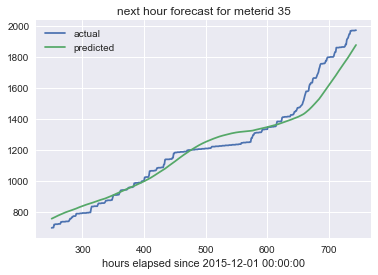

In [54]:
rolling_walk_forward_val(X, y, window_size=250)

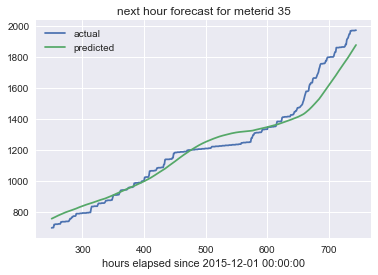

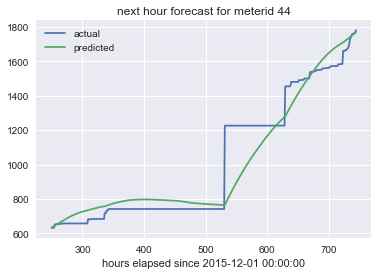

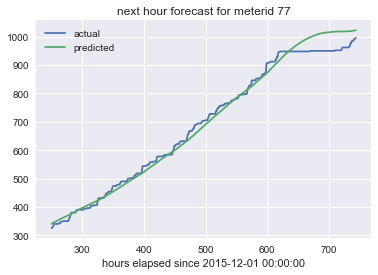

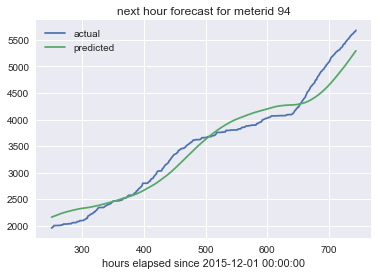

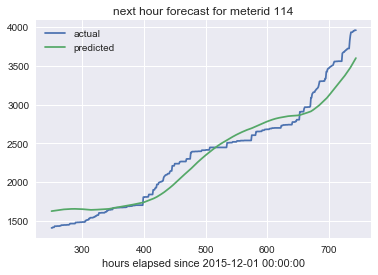

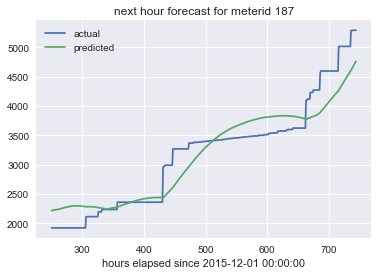

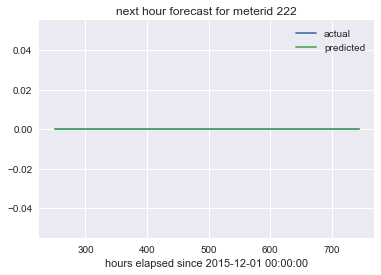

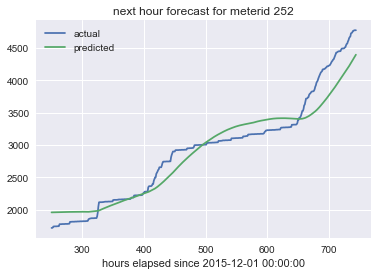

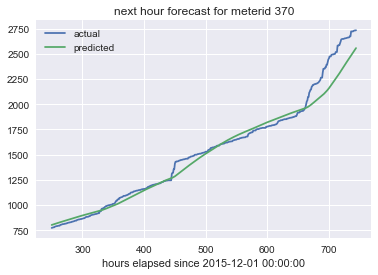

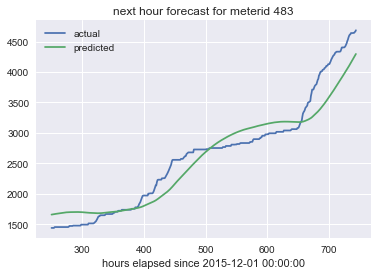

In [56]:
for meterid in new_id_list[0:10]:
    X, x_train, x_valid, x_test, y, y_train, y_valid, y_test = split_data(origin_date, end_date, meterid=meterid)
    rolling_walk_forward_val(X, y, window_size=250)

## SVR

In [57]:
from sklearn.svm import SVR
model = SVR(kernel='poly', degree=3, C=1e-3, gamma='auto', epsilon=.1)

meterid = 35
X, x_train, x_valid, x_test, y, y_train, y_valid, y_test = split_data(origin_date, end_date, meterid=meterid)
scores = []

In [58]:
model.fit(X=x_train, y=y_train)
dump(model, f'models/svr/svr_{meterid}.joblib') # save model to hard disk.

# record coefficients
#coeffs.append((model.intercept_, model.coef_))

#run predictions and get scores
y_train_pred = model.predict(x_train)
r2_train = model.score(x_train, y_train)

y_valid_pred = model.predict(x_valid)
r2_valid = model.score(x_valid, y_valid)

y_test_pred = model.predict(x_test)
r2_test = model.score(x_test, y_test)

# record scores
scores.append((r2_train, r2_valid, r2_test))

In [59]:
show_plot = True

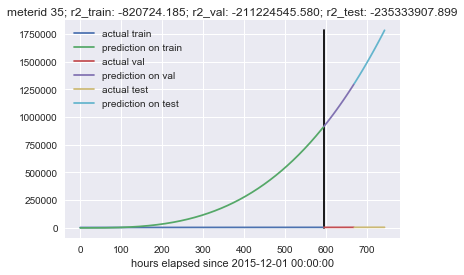

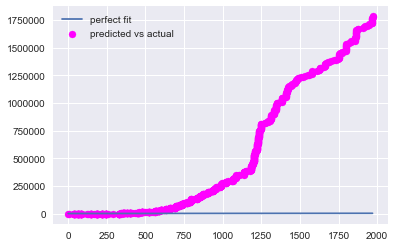

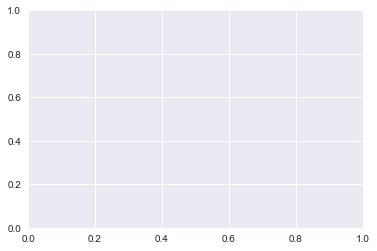

In [60]:
# show residual plots and prediction error plots.
if show_plot: 
    # plot line demarcating end of training data.
    test_mark = X[valid_start][0]
    plt.plot([test_mark, test_mark], [y_train_pred.min(), y_test_pred.max()], 'k-')

    # plot trendline and actual line.
    plt.title(f'meterid {meterid}; r2_train: {r2_train:.3f}; r2_val: {r2_valid:.3f}; r2_test: {r2_test:.3f}')
    plt.xlabel(f'hours elapsed since {df_i.localminute.iloc[0]}') 
    plt.plot(x_train, y_train, label='actual train')
    plt.plot(x_train, y_train_pred, label='prediction on train')

    plt.plot(x_valid, y_valid, label='actual val')
    plt.plot(x_valid, y_valid_pred, label='prediction on val')

    plt.plot(x_test, y_test, label='actual test')
    plt.plot(x_test, y_test_pred, label='prediction on test')

    plt.legend()
    plt.show()
    plt.cla()

    # plot prediction error plot (actual vs predicted value)
    actual = []
    actual.extend(y_train)
    actual.extend(y_valid)
    actual.extend(y_test)
    len(actual)

    predicted = []
    predicted.extend(y_train_pred)
    predicted.extend(y_valid_pred)
    predicted.extend(y_test_pred)
    len(predicted)

    plt.scatter(actual, predicted, color='magenta', label='predicted vs actual')
    plt.plot(actual, actual, label='perfect fit')
    plt.legend()

    plt.show()
    plt.cla()

In [61]:
#TODO: iterate SVR modelling and analysis for all valid meterids

### LASSO

[143446.36840682852, 2710.171267074011, 937.1935906977437, 1107.679080612792, 1097.4740610627487, 1096.2975755417217, 1095.9732209955087, 1095.227095587753, 1091.4460407649094, 1091.8849073382785, 1086.938016332699, 1088.576783557188, 1092.1781732753095, 1090.5866545834197, 1090.6245740384234, 1090.2298554478884, 1083.3867962929219, 1082.9717817678145, 1080.8649239816255]


(0, 20)

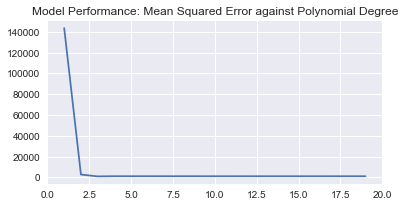

In [62]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

## Iterating through the different polynomial degrees
## Trend is that after degree 3, MSE seems constant.
mse_list = []
for deg in range(1,20):
    ls = Lasso(alpha=0.005, max_iter = 10000000, tol = 0.008)
    ls.fit(np.vander(x_train.flatten(), deg), y_train)
    y_train_pred = ls.predict(np.vander(x_train.flatten(), deg))
    mse_list.append(mean_squared_error(y_train, y_train_pred))
    
print(mse_list)
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # plot settings
ax.plot(range(1,20),mse_list)
plt.title('Model Performance: Mean Squared Error against Polynomial Degree')
ax.set_xlim(0,20)

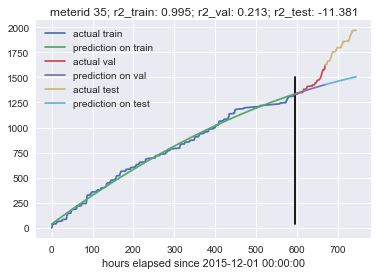

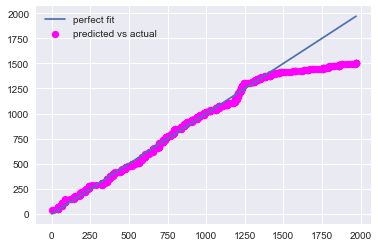

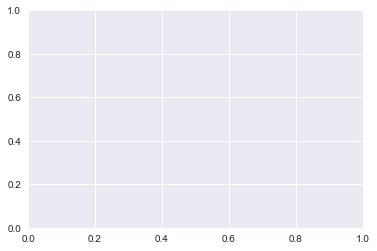

In [63]:
# Create the Model
model = Lasso(alpha=1e-4, max_iter = 1e6, tol = 0.0040)
deg = 3  # chosen from graph in previous cell.

# Train the model on our training dataset
model.fit(np.vander(x_train.flatten(), deg), y_train)
dump(model, f'models/svr/svr_{meterid}.joblib') # save model to hard disk.

# record coefficients
#coeffs.append((model.intercept_, model.coef_))

#run predictions and get scores
y_train_pred = model.predict(np.vander(x_train.flatten(), deg))
r2_train = model.score(np.vander(x_train.flatten(), deg), y_train)

y_valid_pred = model.predict(np.vander(x_valid.flatten(), deg))
r2_valid = model.score(np.vander(x_valid.flatten(), deg), y_valid)

y_test_pred = model.predict(np.vander(x_test.flatten(), deg))
r2_test = model.score(np.vander(x_test.flatten(), deg), y_test)

# record scores
scores.append((r2_train, r2_valid, r2_test))

if show_plot: 
    # plot line demarcating end of training data.
    test_mark = X[valid_start][0]
    plt.plot([test_mark, test_mark], [y_train_pred.min(), y_test_pred.max()], 'k-')

    # plot trendline and actual line.
    plt.title(f'meterid {meterid}; r2_train: {r2_train:.3f}; r2_val: {r2_valid:.3f}; r2_test: {r2_test:.3f}')
    plt.xlabel(f'hours elapsed since {df_i.localminute.iloc[0]}') 
    plt.plot(x_train, y_train, label='actual train')
    plt.plot(x_train, y_train_pred, label='prediction on train')

    plt.plot(x_valid, y_valid, label='actual val')
    plt.plot(x_valid, y_valid_pred, label='prediction on val')

    plt.plot(x_test, y_test, label='actual test')
    plt.plot(x_test, y_test_pred, label='prediction on test')

    plt.legend()
    plt.show()
    plt.cla()

    # plot prediction error plot (actual vs predicted value)
    actual = []
    actual.extend(y_train)
    actual.extend(y_valid)
    actual.extend(y_test)
    len(actual)

    predicted = []
    predicted.extend(y_train_pred)
    predicted.extend(y_valid_pred)
    predicted.extend(y_test_pred)
    len(predicted)

    plt.scatter(actual, predicted, color='magenta', label='predicted vs actual')
    plt.plot(actual, actual, label='perfect fit')
    plt.legend()

    plt.show()
    plt.cla()

In [ ]:
#TODO: iterate LASSO modelling and analysis for all valid meterids